# Week 1: Clustering for Innovation - Part 1
## Setup, Pre-Discovery, and Foundation

This comprehensive notebook covers clustering algorithms for innovation pattern discovery.

**Part 1 Contents:**
- Section 0: Complete Setup & ALL Functions (36 total)
- Section 1: Pre-Discovery Demonstrations (function calls only)
- Section 2: Foundation Demonstrations (function calls only)

**Note:** All code is organized as functions at the beginning for modularity and reusability.

---
# Section 0: Setup & Helper Functions
All helper functions are defined here at the top for easy access throughout the notebook.

## 0.1 Imports and Configuration

In [38]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sklearn clustering algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Sklearn metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances

# Sklearn preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Sklearn decomposition
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Sklearn data generation
from sklearn.datasets import make_blobs, make_moons, make_circles

# Interactive visualizations
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Scipy for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Setup complete! All libraries loaded successfully.")
print(f"Notebook initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Setup complete! All libraries loaded successfully.
Notebook initialized at: 2025-09-16 15:58:12


## 0.2 Visualization Helper Functions

In [73]:
def setup_plot_style():
    """Set consistent style across all plots"""
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['figure.titlesize'] = 18

def get_color_palette():
    """Return standard color palette matching slides"""
    return {
        'mlblue': '#1f77b4',
        'mlorange': '#ff7f0e',
        'mlgreen': '#2ca02c',
        'mlred': '#d62728',
        'mlpurple': '#9467bd',
        'mlbrown': '#8c564b',
        'mlpink': '#e377c2',
        'mlgray': '#7f7f7f',
        'mlyellow': '#bcbd22',
        'mlcyan': '#17becf'
    }

def plot_clusters_2d(X, labels, centers=None, title="Cluster Visualization", 
                     save_path=None, figsize=(12, 8)):
    """Standard 2D cluster visualization"""
    colors = get_color_palette()
    color_list = list(colors.values())
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Handle noise points for DBSCAN
    unique_labels = np.unique(labels)
    
    for i, label in enumerate(unique_labels):
        if label == -1:
            # Noise points
            mask = labels == label
            ax.scatter(X[mask, 0], X[mask, 1], c='gray', 
                      marker='x', s=50, alpha=0.5, label='Noise')
        else:
            mask = labels == label
            ax.scatter(X[mask, 0], X[mask, 1], 
                      c=color_list[label % len(color_list)],
                      s=50, alpha=0.7, edgecolors='black', linewidth=0.5,
                      label=f'Cluster {label}')
    
    # Plot centers if provided
    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], 
                  c='black', marker='*', s=300, 
                  edgecolors='white', linewidth=2,
                  label='Centroids', zorder=10)
    
    ax.set_xlabel('Feature 1', fontsize=12)
    ax.set_ylabel('Feature 2', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    return fig

def plot_clusters_3d(X, labels, title="3D Cluster Visualization", interactive=True):
    """3D cluster visualization with rotation"""
    if interactive:
        # Use plotly for interactive 3D
        fig = go.Figure()
        
        unique_labels = np.unique(labels)
        colors = px.colors.qualitative.Plotly
        
        for i, label in enumerate(unique_labels):
            mask = labels == label
            fig.add_trace(go.Scatter3d(
                x=X[mask, 0], y=X[mask, 1], z=X[mask, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=colors[i % len(colors)],
                    opacity=0.8
                ),
                name=f'Cluster {label}' if label != -1 else 'Noise'
            ))
        
        fig.update_layout(
            title=title,
            scene=dict(
                xaxis_title='Feature 1',
                yaxis_title='Feature 2',
                zaxis_title='Feature 3'
            ),
            height=600,
            showlegend=True
        )
        fig.show()
    else:
        # Use matplotlib for static 3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        unique_labels = np.unique(labels)
        colors = get_color_palette()
        color_list = list(colors.values())
        
        for i, label in enumerate(unique_labels):
            mask = labels == label
            ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                      c=color_list[i % len(color_list)],
                      s=50, alpha=0.7,
                      label=f'Cluster {label}' if label != -1 else 'Noise')
        
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
        ax.set_title(title)
        ax.legend()
        plt.show()
    
    return fig

def plot_elbow_curve(X, k_range=(2, 10), return_scores=False):
    """Generate elbow plot with automatic elbow detection"""
    inertias = []
    silhouettes = []
    k_values = list(range(k_range[0], k_range[1] + 1))
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))
    
    # Find elbow point (simplified method)
    # Calculate rate of change
    deltas = np.diff(inertias)
    delta_ratios = deltas[:-1] / deltas[1:]
    elbow_idx = np.argmax(delta_ratios) + 1
    elbow_k = k_values[elbow_idx]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Inertia plot
    ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Elbow at k={elbow_k}')
    ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax1.set_ylabel('Inertia', fontsize=12)
    ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Silhouette plot
    ax2.plot(k_values, silhouettes, 'go-', linewidth=2, markersize=8)
    best_k = k_values[np.argmax(silhouettes)]
    ax2.axvline(x=best_k, color='red', linestyle='--', alpha=0.7,
                label=f'Best at k={best_k}')
    ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.suptitle('Finding Optimal Number of Clusters', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Elbow method suggests k={elbow_k}")
    print(f"Best silhouette score at k={best_k}")
    
    if return_scores:
        return k_values, inertias, silhouettes
    return elbow_k

def plot_silhouette_analysis(X, labels):
    """Detailed silhouette plot per cluster"""
    n_clusters = len(np.unique(labels[labels != -1]))
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    y_lower = 10
    colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
    
    for i in range(n_clusters):
        # Get silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        
        # Label clusters
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
               label=f'Average: {silhouette_avg:.3f}')
    ax.set_xlabel('Silhouette Coefficient', fontsize=12)
    ax.set_ylabel('Cluster', fontsize=12)
    ax.set_title('Silhouette Analysis per Cluster', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print cluster statistics
    print(f"Overall Silhouette Score: {silhouette_avg:.3f}")
    for i in range(n_clusters):
        cluster_scores = sample_silhouette_values[labels == i]
        print(f"Cluster {i}: Mean={cluster_scores.mean():.3f}, "
              f"Min={cluster_scores.min():.3f}, Max={cluster_scores.max():.3f}")

def plot_dendrogram(X, method='ward', truncate_mode=None, max_d=None):
    """Hierarchical clustering dendrogram"""
    plt.figure(figsize=(14, 8))
    
    # Calculate linkage matrix
    linkage_matrix = linkage(X, method=method)
    
    # Plot dendrogram
    dendrogram_plot = dendrogram(
        linkage_matrix,
        truncate_mode=truncate_mode,
        color_threshold=max_d,
        above_threshold_color='gray'
    )
    
    if max_d:
        plt.axhline(y=max_d, c='red', linestyle='--', 
                   label=f'Cut at distance={max_d:.2f}')
    
    plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.title(f'Hierarchical Clustering Dendrogram (Method: {method})', 
             fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return linkage_matrix

def plot_comparison_grid(results_dict):
    """Compare multiple clustering results side by side"""
    n_methods = len(results_dict)
    cols = min(3, n_methods)
    rows = (n_methods + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if n_methods == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    colors = get_color_palette()
    color_list = list(colors.values())
    
    for idx, (method_name, data) in enumerate(results_dict.items()):
        ax = axes[idx]
        X = data['X']
        labels = data['labels']
        
        unique_labels = np.unique(labels)
        for i, label in enumerate(unique_labels):
            mask = labels == label
            if label == -1:
                ax.scatter(X[mask, 0], X[mask, 1], c='gray', 
                          marker='x', s=30, alpha=0.5)
            else:
                ax.scatter(X[mask, 0], X[mask, 1], 
                          c=color_list[label % len(color_list)],
                          s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
        
        # Add centers if available
        if 'centers' in data and data['centers'] is not None:
            ax.scatter(data['centers'][:, 0], data['centers'][:, 1],
                      c='black', marker='*', s=200, 
                      edgecolors='white', linewidth=1.5)
        
        # Add metrics if available
        title = method_name
        if 'metrics' in data:
            metrics = data['metrics']
            title += f"\nSilhouette: {metrics.get('silhouette', 0):.3f}"
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Clustering Algorithm Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Initialize plot style
setup_plot_style()
print("Visualization functions loaded successfully!")
# ============================================================================# PRE-DISCOVERY DEMONSTRATION FUNCTIONS# ============================================================================
def demonstrate_innovation_data_types():    
    """Show different types of innovation data."""    
    print("🔍 Types of Innovation Data\n")        
    # Create sample datasets    
    data_types = {        
        'Customer Feedback': pd.DataFrame({            
        'satisfaction': np.random.uniform(1, 10, 100),
        'engagement': np.random.uniform(0, 100, 100),
        'retention': np.random.uniform(0, 1, 100)
        }),        
        'Product Features': pd.DataFrame({            
            'complexity': np.random.uniform(1, 10, 50),            
            'cost': np.random.uniform(100, 10000, 50),            
            'time_to_market': np.random.uniform(1, 24, 50)
        }),        
        'Market Segments': pd.DataFrame({            
            'size': np.random.uniform(1000, 100000, 30),            
            'growth_rate': np.random.uniform(-0.1, 0.5, 30),            
            'competition': np.random.uniform(1, 10, 30)        
        })    }        
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))        
    for idx, (name, df) in enumerate(data_types.items()):        
        ax = axes[idx]        
        ax.scatter(df.iloc[:, 0], df.iloc[:, 1], alpha=0.6, s=50)        
        ax.set_title(name, fontweight='bold')        
        ax.set_xlabel(df.columns[0].replace('_', ' ').title())        
        ax.set_ylabel(df.columns[1].replace('_', ' ').title())        
        ax.grid(True, alpha=0.3)        
        plt.suptitle('Different Types of Innovation Data', fontsize=14, fontweight='bold')    
        plt.tight_layout()    
        plt.show()        
        print("\n💡 Each type requires different clustering approaches!")    
        return data_types
def demonstrate_scale_challenge():    
    """Demonstrate the challenge of scale in innovation analysis."""    
    print("📊 The Scale Challenge in Innovation\n")        
    # Show increasing data sizes    
    sizes = [10, 100, 1000, 10000]    
    times = []        
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))    
    axes = axes.flatten()        
    for idx, n in enumerate(sizes):        
        # Generate data        
        import time        
        start = time.time()        
        X = np.random.randn(n, 2)                
        # Cluster        
        kmeans = KMeans(n_clusters=min(5, n//10), random_state=42)        
        labels = kmeans.fit_predict(X)        
        elapsed = time.time() - start        
        times.append(elapsed)                
        # Visualize        
        ax = axes[idx]        
        if n <= 1000:            
            ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, alpha=0.6, cmap='viridis')        
        else:            
            # Sample for visualization            
            sample_idx = np.random.choice(n, 1000, replace=False)            
            ax.scatter(X[sample_idx, 0], X[sample_idx, 1], c=labels[sample_idx], s=20, alpha=0.6, cmap='viridis')                
            ax.set_title(f'{n:,} Data Points\nTime: {elapsed:.3f}s', fontweight='bold')        
            ax.set_xlabel('Feature 1')        
            ax.set_ylabel('Feature 2')        
            plt.suptitle('Scaling Challenge: More Data = More Complexity', fontsize=14, fontweight='bold')    
            plt.tight_layout()    
            plt.show()        
            print(f"\n📈 Processing time scaling: {times}")    
            print("💡 Clustering helps manage large-scale innovation data efficiently!")
def demonstrate_hidden_patterns():    
    """Show how patterns are hidden in raw data."""    
    print("🔮 Finding Hidden Patterns\n")        
    # Generate data with hidden structure    
    np.random.seed(42)        
    # Create three hidden groups    
    group1 = np.random.multivariate_normal([2, 2], [[0.5, 0.3], [0.3, 0.5]], 100)    
    group2 = np.random.multivariate_normal([6, 2], [[0.5, -0.3], [-0.3, 0.5]], 100)    
    group3 = np.random.multivariate_normal([4, 6], [[0.8, 0], [0, 0.8]], 100)        
    X_hidden = np.vstack([group1, group2, group3])        
    # Add noise dimension    
    X_hidden = np.column_stack([X_hidden, np.random.randn(300)])        
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))        
    # Raw data - patterns not visible    
    ax1 = axes[0]    
    ax1.scatter(X_hidden[:, 0], X_hidden[:, 1], c='gray', alpha=0.5, s=30)    
    ax1.set_title('Raw Data\n(Patterns Hidden)', fontweight='bold')    
    ax1.set_xlabel('Innovation Score')    
    ax1.set_ylabel('Market Potential')        
    # With color coding (if we knew the groups)    
    ax2 = axes[1]    
    true_labels = np.repeat([0, 1, 2], 100)    
    ax2.scatter(X_hidden[:, 0], X_hidden[:, 1], c=true_labels,cmap='viridis', alpha=0.6, s=30)    
    ax2.set_title('Hidden Structure\n(If We Knew)', fontweight='bold')    
    ax2.set_xlabel('Innovation Score')    
    ax2.set_ylabel('Market Potential')        
    # After clustering    
    ax3 = axes[2]    
    kmeans = KMeans(n_clusters=3, random_state=42)    
    predicted_labels = kmeans.fit_predict(X_hidden)    
    ax3.scatter(X_hidden[:, 0], X_hidden[:, 1], c=predicted_labels, cmap='viridis', alpha=0.6, s=30)    
    ax3.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='*', s=300, edgecolors='black', linewidth=2)   
    ax3.set_title('Patterns Revealed\n(After Clustering)', fontweight='bold')    
    ax3.set_xlabel('Innovation Score')    
    ax3.set_ylabel('Market Potential')        
    plt.suptitle('Clustering Reveals Hidden Innovation Patterns', fontsize=14, fontweight='bold')    
    plt.tight_layout()    
    plt.show()        
    print("\n✨ Clustering transforms chaos into clarity!")    
    return X_hidden
def interactive_pattern_exercise():    
    """Interactive exercise for pattern recognition."""    
    print("🎯 Interactive Exercise: Can You Spot the Patterns?\n")        
    # Generate ambiguous data    
    np.random.seed(42)    
    n_samples = 200        
    # Create data that could be 2, 3, or 4 clusters    
    X_ambiguous = np.random.randn(n_samples, 2)    
    X_ambiguous[:50] += [2, 2]    
    X_ambiguous[50:100] += [2, -2]    
    X_ambiguous[100:150] += [-2, 0]    
    X_ambiguous[150:] += [0, 0]  # Overlapping with others        
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))        
    # Show raw data    
    axes[0, 0].scatter(X_ambiguous[:, 0], X_ambiguous[:, 1], c='gray', alpha=0.5, s=30)    
    axes[0, 0].set_title('Raw Data\nHow many groups do you see?', fontweight='bold')        
    # Try different K values    
    for idx, k in enumerate([2, 3, 4]):        
        kmeans = KMeans(n_clusters=k, random_state=42)        
        labels = kmeans.fit_predict(X_ambiguous)                
        # Top row: just clusters        
        ax_top = axes[0, idx]        
        ax_top.scatter(X_ambiguous[:, 0], X_ambiguous[:, 1],
                       c=labels, cmap='viridis', alpha=0.6, s=30)        
        ax_top.set_title(f'K = {k}', fontweight='bold')                
        # Bottom row: with metrics        
        ax_bottom = axes[1, idx]        
        ax_bottom.scatter(X_ambiguous[:, 0], X_ambiguous[:, 1],                          
                          c=labels, cmap='viridis', alpha=0.6, s=30)                
        silhouette = silhouette_score(X_ambiguous, labels)        
        ax_bottom.set_title(f'K = {k}\nSilhouette: {silhouette:.3f}',                            
                            fontweight='bold')        
        plt.suptitle('Pattern Recognition Exercise: Finding the Right K',                 
                     fontsize=14, fontweight='bold')    
        plt.tight_layout()    
        plt.show()        
        print("\n📊 Results:")    
        print("• K=2: Clear separation (might be too simple)")    
        print("• K=3: Good balance")    
        print("• K=4: Possibly overfitting")    
        print("\n💡 Lesson: Use metrics + domain knowledge to decide!")
# ============================================================================# FOUNDATION DEMONSTRATION FUNCTIONS# ============================================================================
def demonstrate_innovation_discovery():    
    """Show the innovation discovery process."""    
    print("🚀 Innovation Discovery Process\n")        
    # Simulate innovation discovery pipeline    
    stages = {        
        'Raw Ideas': np.random.randn(500, 2) * 3,        
        'Initial Filter': np.random.randn(300, 2) * 2.5,        
        'Refined Concepts': np.random.randn(150, 2) * 2,        
        'Final Innovations': np.random.randn(50, 2) * 1.5    
    }        
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))        
    for idx, (stage, data) in enumerate(stages.items()):        
        ax = axes[idx]                
        # Apply clustering at each stage        
        n_clusters = max(2, len(data) // 50)        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)        
        labels = kmeans.fit_predict(data)                
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels,                            
                             cmap='viridis', alpha=0.6, s=30)        
        ax.set_title(f'{stage}\n({len(data)} items)', fontweight='bold')        
        ax.set_xlabel('Innovation Score')        
        ax.set_ylabel('Feasibility')                
        # Add stage number        
        ax.text(0.5, 0.95, f'Stage {idx+1}',                
                transform=ax.transAxes, ha='center', fontsize=10,               
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))        
        plt.suptitle('Innovation Discovery Pipeline: From Ideas to Implementation',                 
                     fontsize=14, fontweight='bold')    
        plt.tight_layout()    
        plt.show()        
        print("\n📈 Pipeline Benefits:")    
        print("• Stage 1: Capture all ideas")    
        print("• Stage 2: Group similar concepts")    
        print("• Stage 3: Identify promising clusters")    
        print("• Stage 4: Focus on best opportunities")        
        return stages
def demonstrate_hidden_complexity():    
    """Demonstrate hidden complexity in simple-looking data."""    
    print("🌐 Hidden Complexity in Innovation Data\n")        
    # Create data with hidden complexity    
    np.random.seed(42)        
    # Simple 2D view    
    X_2d = np.random.randn(300, 2)        
    # Actually has complex 5D structure    
    X_5d = np.random.randn(300, 5)    
    X_5d[:100] = np.random.randn(100, 5) + [2, 0, 1, -1, 0]    
    X_5d[100:200] = np.random.randn(100, 5) + [-2, 1, 0, 0, 2]    
    X_5d[200:] = np.random.randn(100, 5) + [0, -1, -1, 2, -2]        
    # Project to 2D for visualization    
    pca = PCA(n_components=2)    
    X_2d_projection = pca.fit_transform(X_5d)        
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))        
    # Row 1: Different 2D projections    
    for i in range(3):        
        ax = axes[0, i]        
        ax.scatter(X_5d[:, i], X_5d[:, (i+1)%5], c='gray', alpha=0.5, s=30)        
        ax.set_title(f'Features {i+1} vs {(i+2)%5+1}', fontweight='bold')        
        ax.set_xlabel(f'Feature {i+1}')        
        ax.set_ylabel(f'Feature {(i+2)%5+1}')        
        # Row 2: Clustering results    
        # 2D clustering    
        kmeans_2d = KMeans(n_clusters=3, random_state=42)    
        labels_2d = kmeans_2d.fit_predict(X_2d_projection)    
        axes[1, 0].scatter(X_2d_projection[:, 0], X_2d_projection[:, 1],                       
                           c=labels_2d, cmap='viridis', alpha=0.6, s=30)    
        axes[1, 0].set_title('2D Clustering', fontweight='bold')        
        # 5D clustering    
        kmeans_5d = KMeans(n_clusters=3, random_state=42)    
        labels_5d = kmeans_5d.fit_predict(X_5d)    
        axes[1, 1].scatter(X_2d_projection[:, 0], X_2d_projection[:, 1],                       
                           c=labels_5d, cmap='viridis', alpha=0.6, s=30)    
        axes[1, 1].set_title('5D Clustering (shown in 2D)', fontweight='bold')        
        # True structure    
        true_labels = np.repeat([0, 1, 2], 100)    
        axes[1, 2].scatter(X_2d_projection[:, 0], X_2d_projection[:, 1],                       
                           c=true_labels, cmap='viridis', alpha=0.6, s=30)    
        axes[1, 2].set_title('True Structure', fontweight='bold')        
        plt.suptitle('Hidden Complexity: What You See Is Not All There Is',                 
                     fontsize=14, fontweight='bold')    
        plt.tight_layout()    
        plt.show()        
        print("\n🔍 Key Insights:")    
        print("• 2D views miss important patterns")    
        print("• Higher dimensions reveal true structure")    
        print("• Multiple features capture full complexity")    
        print("• Clustering works in high dimensions!")
def compare_traditional_vs_ai():    
    """Compare traditional analysis vs AI-powered clustering."""    
    print("⚖️ Traditional Analysis vs AI-Powered Clustering\n")        
    # Generate complex innovation data    
    np.random.seed(42)    
    n_innovations = 200        
    # Create data with non-linear patterns    
    theta = np.random.uniform(0, 2*np.pi, n_innovations)    
    r = np.random.uniform(0, 3, n_innovations)    
    X = np.column_stack([r * np.cos(theta), r * np.sin(theta)])        
    # Add third cluster in center    
    X[::3] = np.random.randn(len(X[::3]), 2) * 0.3        
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))        
    # Traditional approach (manual thresholds)    
    ax1 = axes[0, 0]    
    traditional_labels = np.zeros(len(X))    
    traditional_labels[X[:, 0] > 1] = 1    
    traditional_labels[X[:, 1] > 1] = 2    
    ax1.scatter(X[:, 0], X[:, 1], c=traditional_labels,                
                cmap='viridis', alpha=0.6, s=30)    
    ax1.set_title('Traditional\n(Manual Rules)', fontweight='bold')    
    ax1.axvline(x=1, color='red', linestyle='--', alpha=0.5)    
    ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5)        
    # K-means    
    ax2 = axes[0, 1]    
    kmeans = KMeans(n_clusters=3, random_state=42)    
    kmeans_labels = kmeans.fit_predict(X)    
    ax2.scatter(X[:, 0], X[:, 1], c=kmeans_labels,                
                cmap='viridis', alpha=0.6, s=30)    
    ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],               
                c='red', marker='*', s=300, edgecolors='black', linewidth=2)    
    ax2.set_title('AI: K-Means', fontweight='bold')        
    # DBSCAN    
    ax3 = axes[0, 2]    
    dbscan = DBSCAN(eps=0.5, min_samples=5)    
    dbscan_labels = dbscan.fit_predict(X)    
    ax3.scatter(X[:, 0], X[:, 1], c=dbscan_labels,                
                cmap='viridis', alpha=0.6, s=30)    
    ax3.set_title('AI: DBSCAN', fontweight='bold')        
    # Performance comparison    
    ax4 = axes[1, 0]    
    methods = ['Traditional', 'K-Means', 'DBSCAN']    
    scores = [        -0.1,  # Traditional performs poorly        
              silhouette_score(X, kmeans_labels),        
              silhouette_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else -0.2    ]    
    bars = ax4.bar(methods, scores, color=['red', 'green', 'blue'])    
    ax4.set_title('Performance Comparison', fontweight='bold')    
    ax4.set_ylabel('Silhouette Score')    
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)        
    # Scalability    
    ax5 = axes[1, 1]    
    data_sizes = [100, 1000, 10000, 100000]    
    traditional_time = [0.01, 0.1, 10, 1000]  
    # Exponential growth    
    ai_time = [0.01, 0.05, 0.2, 1]  
    # Much better scaling    
    ax5.semilogy(data_sizes, traditional_time, 'r-o', label='Traditional')    
    ax5.semilogy(data_sizes, ai_time, 'g-o', label='AI-Powered')    
    ax5.set_xlabel('Data Size')    
    ax5.set_ylabel('Processing Time (s)')    
    ax5.set_title('Scalability', fontweight='bold')    
    ax5.legend()    
    ax5.grid(True, alpha=0.3)        
    # Adaptability    
    ax6 = axes[1, 2]    
    capabilities = ['Linear\nPatterns', 'Non-linear\nPatterns', 'Outlier\nHandling',                    
                    'Auto\nOptimization', 'High\nDimensions']    
    traditional_scores = [3, 1, 1, 0, 1]    
    ai_scores = [5, 5, 4, 5, 5]        
    x = np.arange(len(capabilities))    
    width = 0.35    
    ax6.bar(x - width/2, traditional_scores, width, label='Traditional', color='red', alpha=0.7)    
    ax6.bar(x + width/2, ai_scores, width, label='AI-Powered', color='green', alpha=0.7)    
    ax6.set_xticks(x)    
    ax6.set_xticklabels(capabilities, fontsize=9)    
    ax6.set_ylabel('Capability Score')    
    ax6.set_title('Capability Comparison', fontweight='bold')    
    ax6.legend()        
    plt.suptitle('Traditional vs AI-Powered Innovation Analysis',                 
                 fontsize=14, fontweight='bold')    
    plt.tight_layout()    
    plt.show()        
    print("\n🏆 AI-Powered Advantages:")    
    print("• Finds complex patterns automatically")    
    print("• Scales to massive datasets")    
    print("• Adapts to data structure")    
    print("• No manual rule creation needed")
def demonstrate_dual_pipeline():    
    """Show the dual pipeline: ML + Design Thinking."""    
    print("🔄 Dual Pipeline: ML + Design Thinking\n")        
    fig, axes = plt.subplots(2, 5, figsize=(16, 8))        
    # ML Pipeline (top row)    
    ml_stages = ['Data', 'Preprocess', 'Model', 'Evaluate', 'Deploy']    
    colors_ml = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#DDA77B']        
    for i, (stage, color) in enumerate(zip(ml_stages, colors_ml)):        
        ax = axes[0, i]                
        # Create visual representation        
        circle = plt.Circle((0.5, 0.5), 0.3, color=color, alpha=0.7)        
        ax.add_patch(circle)        
        ax.text(0.5, 0.5, stage, ha='center', va='center',                
        fontsize=11, fontweight='bold')                
        # Add connections        
        if i < len(ml_stages) - 1:            
            ax.arrow(0.85, 0.5, 0.1, 0, head_width=0.05, head_length=0.03, fc='gray', ec='gray')                
            ax.set_xlim(0, 1)        
            ax.set_ylim(0, 1)        
            ax.set_aspect('equal')        
            ax.axis('off')                
        # Add description        
        descriptions = [            
        'Innovation\nData',            
        'Clean &\nScale',            
        'Cluster\nAnalysis',            
        'Validate\nResults',            
        'Innovation\nInsights'        
        ]        
        ax.text(0.5, 0.1, descriptions[i], ha='center', fontsize=9,                
            style='italic', color='gray')        
        # Design Pipeline (bottom row)    
        design_stages = ['Empathize', 'Define', 'Ideate', 'Prototype', 'Test']    
        colors_design = ['#FF6B9D', '#C44569', '#F8961E', '#90BE6D', '#577590']        
    for i, (stage, color) in enumerate(zip(design_stages, colors_design)):        
        ax = axes[1, i]                
        # Create visual representation        
        diamond = plt.Polygon([(0.5, 0.2), (0.8, 0.5), (0.5, 0.8), (0.2, 0.5)],                             
                              color=color, alpha=0.7)        
        ax.add_patch(diamond)        
        ax.text(0.5, 0.5, stage, ha='center', va='center',                
                fontsize=11, fontweight='bold')                
    # Add connections        
    if i < len(design_stages) - 1:            
        ax.arrow(0.85, 0.5, 0.1, 0, head_width=0.05,                     
                 head_length=0.03, fc='gray', ec='gray')                
        ax.set_xlim(0, 1)        
        ax.set_ylim(0, 1)        
        ax.set_aspect('equal')        
        ax.axis('off')                
        # Add ML integration points        
        ml_integration = [            
            'Cluster\nUsers',            
            'Pattern\nAnalysis',            
            'Generate\nConcepts',            
            'Test\nVariations',            
            'Validate\nResults'        
        ]        
        ax.text(0.5, 0.9, ml_integration[i], ha='center', fontsize=9,                
                style='italic', color='blue')        
        # Add pipeline labels    
        fig.text(0.08, 0.75, 'ML Pipeline', fontsize=14, fontweight='bold',             
                 rotation=90, va='center')    
        fig.text(0.08, 0.25, 'Design Pipeline', fontsize=14, fontweight='bold',             
                 rotation=90, va='center')        
        plt.suptitle('Integrated Innovation Process: ML + Design Thinking',                 
                     fontsize=16, fontweight='bold')    
        plt.tight_layout()    
        plt.show()        
        print("\n🔗 Integration Benefits:")    
        print("• ML provides data-driven insights")    
        print("• Design ensures human-centered solutions")    
        print("• Parallel processing accelerates innovation")    
        print("• Continuous feedback improves both pipelines")
def demonstrate_convergence_flow():    
    """Demonstrate how insights converge through the pipeline."""    
    print("🎯 Convergence: From Many to Few\n")        
    # Create convergence visualization    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))        
    # Define stages and their data points    
    stages = [        
    ('Raw Ideas', 1000, 0),        
    ('Clustered Concepts', 100, 1),        
    ('Refined Groups', 20, 2),        
    ('Key Themes', 5, 3),        
    ('Innovation Focus', 1, 4)    
    ]        
    # Create funnel visualization    
    y_positions = np.linspace(0.9, 0.1, len(stages))        
    for i, (stage, count, x_pos) in enumerate(stages):        
        y = y_positions[i]        
        width = np.log10(count + 1) / 4  # Width based on count                
        # Draw trapezoid for funnel effect        
        if i < len(stages) - 1:            
            next_width = np.log10(stages[i+1][1] + 1) / 4            
            next_y = y_positions[i+1]                        
            trapezoid = plt.Polygon([                
                (0.5 - width, y),                
                (0.5 + width, y),                
                (0.5 + next_width, next_y),                
                (0.5 - next_width, next_y)            
            ], alpha=0.3, color=plt.cm.viridis(i/len(stages)))            
    ax.add_patch(trapezoid)                
    # Add stage labels        
    ax.text(0.5, y, f'{stage}\n({count:,} items)',                
            ha='center', va='center', fontsize=12, fontweight='bold',               
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))                
    # Add process labels on the side        
    processes = ['Collect', 'Cluster', 'Analyze', 'Synthesize', 'Focus']        
    if i < len(stages) - 1:            
        ax.text(0.9, (y + y_positions[i+1])/2, processes[i],                    
                ha='center', va='center', fontsize=10, style='italic',                   
                color='gray')                        
        # Add arrow            
        ax.annotate('', xy=(0.85, y_positions[i+1] + 0.02),                        
                    xytext=(0.85, y - 0.02),                       
                    arrowprops=dict(arrowstyle='->', color='gray', lw=2))        
        ax.set_xlim(0, 1)    
        ax.set_ylim(0, 1)    
        ax.axis('off')        
        # Add title and description    
        ax.text(0.5, 0.95, 'Innovation Convergence Process',            
                ha='center', fontsize=16, fontweight='bold')    
        ax.text(0.5, 0.02, 'Clustering helps filter and focus innovation efforts',            
                ha='center', fontsize=12, style='italic', color='gray')        
        # Add benefit annotations    
        benefits = [        
            (0.1, 0.8, 'Volume'),        
            (0.1, 0.5, 'Quality'),        
            (0.1, 0.2, 'Focus')    
        ]        
        for x, y, text in benefits:        
            ax.text(x, y, text, fontsize=11, fontweight='bold', color='blue')        
            plt.show()        
            print("\n📊 Convergence Metrics:")    
            for stage, count, _ in stages:        
                print(f"• {stage}: {count:,} items")        
        print("\n✨ Result: 1000x reduction while preserving key insights!")
                        # Add these functions to the existing source
                    

Visualization functions loaded successfully!


## 0.3 Data Generation Functions

In [74]:
def generate_innovation_data(n_samples=5000, n_features=10, n_clusters=5, 
                           noise=0.1, random_state=42):
    """Generate synthetic innovation dataset with realistic properties"""
    np.random.seed(random_state)
    
    # Create base clusters with different characteristics
    X, y = make_blobs(n_samples=n_samples, 
                     n_features=n_features,
                     centers=n_clusters,
                     cluster_std=1.5,
                     random_state=random_state)
    
    # Add noise
    X += np.random.normal(0, noise, X.shape)
    
    # Create DataFrame with meaningful feature names
    feature_names = [
        'Tech_Sophistication', 'Market_Readiness', 'Resource_Requirements',
        'User_Engagement', 'Scalability', 'Innovation_Level',
        'Competition_Intensity', 'Regulatory_Complexity', 'ROI_Potential',
        'Implementation_Time'
    ][:n_features]
    
    df = pd.DataFrame(X, columns=feature_names)
    df['True_Cluster'] = y
    
    # Add innovation type labels
    innovation_types = ['Disruptive', 'Incremental', 'Platform', 'Service', 'Hybrid']
    df['Innovation_Type'] = df['True_Cluster'].apply(
        lambda x: innovation_types[x % len(innovation_types)]
    )
    
    print(f"Generated innovation dataset:")
    print(f"  - Samples: {n_samples}")
    print(f"  - Features: {n_features}")
    print(f"  - Clusters: {n_clusters}")
    print(f"  - Shape: {df.shape}")
    
    return df

def generate_blob_data(n_samples=1000, centers=3, cluster_std=1.0, random_state=42):
    """Simple blob data for demonstrations"""
    X, y = make_blobs(n_samples=n_samples,
                     centers=centers,
                     n_features=2,
                     cluster_std=cluster_std,
                     random_state=random_state)
    return X, y

def generate_complex_shapes(n_samples=1000, noise=0.05):
    """Generate moons, circles, anisotropic data for DBSCAN demo"""
    datasets = {}
    
    # Two moons
    X_moons, y_moons = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    datasets['moons'] = {'X': X_moons, 'y': y_moons}
    
    # Concentric circles
    X_circles, y_circles = make_circles(n_samples=n_samples, noise=noise, 
                                        factor=0.5, random_state=42)
    datasets['circles'] = {'X': X_circles, 'y': y_circles}
    
    # Anisotropic blobs
    X_aniso, y_aniso = make_blobs(n_samples=n_samples, centers=3, random_state=42)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X_aniso, transformation)
    datasets['anisotropic'] = {'X': X_aniso, 'y': y_aniso}
    
    # Varied density
    X_varied = []
    y_varied = []
    
    # Dense cluster
    X1, y1 = make_blobs(n_samples=n_samples//3, centers=1, 
                       cluster_std=0.2, random_state=42)
    X_varied.append(X1)
    y_varied.extend([0] * len(X1))
    
    # Medium cluster
    X2, y2 = make_blobs(n_samples=n_samples//3, centers=1, 
                       cluster_std=0.5, center_box=(3, 3), random_state=42)
    X_varied.append(X2)
    y_varied.extend([1] * len(X2))
    
    # Sparse cluster
    X3, y3 = make_blobs(n_samples=n_samples//3, centers=1, 
                       cluster_std=1.0, center_box=(-3, -3), random_state=42)
    X_varied.append(X3)
    y_varied.extend([2] * len(X3))
    
    X_varied = np.vstack(X_varied)
    datasets['varied_density'] = {'X': X_varied, 'y': np.array(y_varied)}
    
    return datasets

def add_innovation_context(X, feature_names=None):
    """Add meaningful innovation context to data"""
    n_samples, n_features = X.shape
    
    if feature_names is None:
        feature_names = [f'Feature_{i+1}' for i in range(n_features)]
    
    df = pd.DataFrame(X, columns=feature_names)
    
    # Add synthetic metadata
    df['Innovation_ID'] = [f'INNO_{i:04d}' for i in range(n_samples)]
    df['Submission_Date'] = pd.date_range(start='2024-01-01', periods=n_samples, freq='H')
    df['Department'] = np.random.choice(['R&D', 'Marketing', 'Operations', 
                                        'Sales', 'IT'], n_samples)
    df['Priority'] = np.random.choice(['Low', 'Medium', 'High', 'Critical'], 
                                     n_samples, p=[0.2, 0.4, 0.3, 0.1])
    
    return df

print("Data generation functions loaded successfully!")

Data generation functions loaded successfully!


## 0.4 Clustering Helper Functions

In [75]:
def standardize_data(X, method='standard'):
    """Standardize data with different methods"""
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaling method: {method}")
    
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def find_optimal_k(X, k_range=(2, 10), method='elbow'):
    """Find optimal number of clusters using various methods"""
    results = {'k': [], 'inertia': [], 'silhouette': [], 
              'davies_bouldin': [], 'calinski_harabasz': []}
    
    for k in range(k_range[0], k_range[1] + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        results['k'].append(k)
        results['inertia'].append(kmeans.inertia_)
        results['silhouette'].append(silhouette_score(X, labels))
        results['davies_bouldin'].append(davies_bouldin_score(X, labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
    
    results_df = pd.DataFrame(results)
    
    # Find optimal k based on method
    if method == 'elbow':
        # Simple elbow detection
        deltas = np.diff(results['inertia'])
        delta_ratios = deltas[:-1] / deltas[1:]
        optimal_k = results['k'][np.argmax(delta_ratios) + 1]
    elif method == 'silhouette':
        optimal_k = results['k'][np.argmax(results['silhouette'])]
    elif method == 'davies_bouldin':
        optimal_k = results['k'][np.argmin(results['davies_bouldin'])]
    elif method == 'calinski_harabasz':
        optimal_k = results['k'][np.argmax(results['calinski_harabasz'])]
    else:
        raise ValueError(f"Unknown method: {method}")
    
    print(f"Optimal k using {method} method: {optimal_k}")
    
    return optimal_k, results_df

def compare_algorithms(X, algorithms_dict, return_details=False):
    """Run multiple algorithms and compare results"""
    results = {}
    
    for name, algorithm in algorithms_dict.items():
        print(f"Running {name}...")
        
        # Fit algorithm
        if hasattr(algorithm, 'fit_predict'):
            labels = algorithm.fit_predict(X)
        else:
            labels = algorithm.fit(X).predict(X)
        
        # Calculate metrics (skip if only one cluster or noise)
        unique_labels = np.unique(labels[labels != -1])
        
        metrics = {}
        if len(unique_labels) > 1:
            metrics['silhouette'] = silhouette_score(X, labels)
            metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
            metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        else:
            metrics['silhouette'] = -1
            metrics['davies_bouldin'] = np.inf
            metrics['calinski_harabasz'] = 0
        
        metrics['n_clusters'] = len(unique_labels)
        metrics['n_noise'] = np.sum(labels == -1)
        
        # Get centers if available
        centers = None
        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
        
        results[name] = {
            'labels': labels,
            'metrics': metrics,
            'centers': centers,
            'X': X
        }
        
        print(f"  Clusters: {metrics['n_clusters']}, "
              f"Silhouette: {metrics['silhouette']:.3f}")
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(
        {name: res['metrics'] for name, res in results.items()}
    ).T
    
    print("\nComparison Summary:")
    print(comparison_df)
    
    if return_details:
        return results, comparison_df
    return comparison_df

def calculate_all_metrics(X, labels):
    """Calculate all clustering metrics"""
    metrics = {}
    
    unique_labels = np.unique(labels[labels != -1])
    n_clusters = len(unique_labels)
    
    if n_clusters > 1:
        metrics['silhouette_score'] = silhouette_score(X, labels)
        metrics['davies_bouldin_index'] = davies_bouldin_score(X, labels)
        metrics['calinski_harabasz_score'] = calinski_harabasz_score(X, labels)
    else:
        metrics['silhouette_score'] = -1
        metrics['davies_bouldin_index'] = np.inf
        metrics['calinski_harabasz_score'] = 0
    
    metrics['n_clusters'] = n_clusters
    metrics['n_noise_points'] = np.sum(labels == -1)
    metrics['noise_ratio'] = metrics['n_noise_points'] / len(labels)
    
    # Cluster sizes
    cluster_sizes = [np.sum(labels == i) for i in unique_labels]
    metrics['min_cluster_size'] = min(cluster_sizes) if cluster_sizes else 0
    metrics['max_cluster_size'] = max(cluster_sizes) if cluster_sizes else 0
    metrics['avg_cluster_size'] = np.mean(cluster_sizes) if cluster_sizes else 0
    metrics['cluster_size_std'] = np.std(cluster_sizes) if cluster_sizes else 0
    
    return metrics

def cluster_summary_stats(X, labels):
    """Generate detailed cluster statistics"""
    unique_labels = np.unique(labels)
    summary_list = []
    
    for label in unique_labels:
        mask = labels == label
        cluster_data = X[mask]
        
        if label == -1:
            cluster_name = 'Noise'
        else:
            cluster_name = f'Cluster {label}'
        
        summary = {
            'Cluster': cluster_name,
            'Size': len(cluster_data),
            'Percentage': len(cluster_data) / len(X) * 100,
            'Mean': cluster_data.mean(axis=0).mean(),
            'Std': cluster_data.std(axis=0).mean(),
            'Min': cluster_data.min(),
            'Max': cluster_data.max()
        }
        
        # Add centroid distance for non-noise clusters
        if label != -1:
            centroid = cluster_data.mean(axis=0)
            distances = np.linalg.norm(cluster_data - centroid, axis=1)
            summary['Avg_Distance_to_Centroid'] = distances.mean()
            summary['Max_Distance_to_Centroid'] = distances.max()
        
        summary_list.append(summary)
    
    summary_df = pd.DataFrame(summary_list)
    return summary_df

print("Clustering helper functions loaded successfully!")

Clustering helper functions loaded successfully!


## 0.5 Innovation Analysis Functions

In [76]:
def create_innovation_archetypes(X, labels, feature_names=None):
    """Map clusters to innovation archetypes"""
    if feature_names is None:
        feature_names = [f'Feature_{i+1}' for i in range(X.shape[1])]
    
    archetypes = []
    unique_labels = np.unique(labels[labels != -1])
    
    archetype_names = [
        'Pioneers', 'Fast Followers', 'Optimizers', 
        'Niche Players', 'Mass Market', 'Disruptors',
        'Incrementalists', 'Platform Builders'
    ]
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        cluster_data = X[mask]
        
        # Calculate cluster characteristics
        centroid = cluster_data.mean(axis=0)
        
        archetype = {
            'Cluster': label,
            'Archetype': archetype_names[i % len(archetype_names)],
            'Size': len(cluster_data),
            'Percentage': len(cluster_data) / len(X) * 100
        }
        
        # Add top features
        top_features_idx = np.argsort(np.abs(centroid))[-3:]
        top_features = [feature_names[idx] for idx in top_features_idx]
        archetype['Key_Features'] = ', '.join(top_features)
        
        # Add characteristics based on centroid values
        avg_value = centroid.mean()
        if avg_value > 0.5:
            archetype['Characteristic'] = 'High Innovation'
        elif avg_value > 0:
            archetype['Characteristic'] = 'Moderate Innovation'
        else:
            archetype['Characteristic'] = 'Conservative Innovation'
        
        archetypes.append(archetype)
    
    archetypes_df = pd.DataFrame(archetypes)
    return archetypes_df

def generate_opportunity_heatmap(X, labels, feature_names=None):
    """Create opportunity heatmap from clusters"""
    if feature_names is None:
        feature_names = [f'Feature_{i+1}' for i in range(X.shape[1])]
    
    unique_labels = np.unique(labels[labels != -1])
    
    # Calculate mean values per cluster per feature
    heatmap_data = []
    
    for label in unique_labels:
        mask = labels == label
        cluster_data = X[mask]
        means = cluster_data.mean(axis=0)
        heatmap_data.append(means)
    
    heatmap_df = pd.DataFrame(heatmap_data, 
                              columns=feature_names,
                              index=[f'Cluster {i}' for i in unique_labels])
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_df, annot=True, fmt='.2f', cmap='RdYlGn', 
               center=0, cbar_kws={'label': 'Opportunity Score'})
    plt.title('Innovation Opportunity Heatmap by Cluster', fontsize=14, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Clusters')
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

def build_priority_matrix(X, labels, impact_col=0, effort_col=1):
    """Build design priority matrix based on impact vs effort"""
    unique_labels = np.unique(labels[labels != -1])
    
    priority_data = []
    
    for label in unique_labels:
        mask = labels == label
        cluster_data = X[mask]
        
        # Calculate average impact and effort
        avg_impact = cluster_data[:, impact_col].mean()
        avg_effort = cluster_data[:, effort_col].mean()
        
        # Determine priority quadrant
        if avg_impact > 0 and avg_effort < 0:
            quadrant = 'Quick Wins'
            priority = 1
        elif avg_impact > 0 and avg_effort > 0:
            quadrant = 'Strategic'
            priority = 2
        elif avg_impact < 0 and avg_effort < 0:
            quadrant = 'Fill-ins'
            priority = 3
        else:
            quadrant = 'Avoid'
            priority = 4
        
        priority_data.append({
            'Cluster': label,
            'Impact': avg_impact,
            'Effort': avg_effort,
            'Quadrant': quadrant,
            'Priority': priority,
            'Size': len(cluster_data)
        })
    
    priority_df = pd.DataFrame(priority_data)
    
    # Plot priority matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = {'Quick Wins': 'green', 'Strategic': 'blue', 
             'Fill-ins': 'orange', 'Avoid': 'red'}
    
    for _, row in priority_df.iterrows():
        ax.scatter(row['Effort'], row['Impact'], 
                  s=row['Size']*50, 
                  c=colors[row['Quadrant']],
                  alpha=0.6, edgecolors='black', linewidth=2)
        ax.annotate(f"C{row['Cluster']}", 
                   (row['Effort'], row['Impact']),
                   ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Add quadrant lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add quadrant labels
    ax.text(0.5, 0.5, 'Strategic', transform=ax.transAxes, 
           fontsize=12, alpha=0.5, ha='center')
    ax.text(0.1, 0.5, 'Quick Wins', transform=ax.transAxes, 
           fontsize=12, alpha=0.5, ha='center')
    ax.text(0.1, 0.1, 'Fill-ins', transform=ax.transAxes, 
           fontsize=12, alpha=0.5, ha='center')
    ax.text(0.5, 0.1, 'Avoid', transform=ax.transAxes, 
           fontsize=12, alpha=0.5, ha='center')
    
    ax.set_xlabel('Effort (Low ← → High)', fontsize=12)
    ax.set_ylabel('Impact (Low ← → High)', fontsize=12)
    ax.set_title('Innovation Priority Matrix', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return priority_df.sort_values('Priority')

def map_innovation_journey(X, labels, time_steps=10):
    """Simulate innovation evolution over time"""
    unique_labels = np.unique(labels[labels != -1])
    n_features = X.shape[1]
    
    # Create time series data for each cluster
    journey_data = {}
    
    for label in unique_labels:
        mask = labels == label
        cluster_data = X[mask]
        
        # Simulate evolution (simplified - just interpolation)
        start_point = cluster_data.mean(axis=0) - cluster_data.std(axis=0)
        end_point = cluster_data.mean(axis=0) + cluster_data.std(axis=0)
        
        journey = []
        for t in range(time_steps):
            alpha = t / (time_steps - 1)
            point = start_point * (1 - alpha) + end_point * alpha
            journey.append(point)
        
        journey_data[f'Cluster {label}'] = np.array(journey)
    
    # Plot journey for first two dimensions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Journey paths
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    for i, (cluster_name, journey) in enumerate(journey_data.items()):
        # Path plot
        ax1.plot(journey[:, 0], journey[:, 1], 'o-', 
                color=colors[i], label=cluster_name, 
                markersize=8, linewidth=2, alpha=0.7)
        
        # Mark start and end
        ax1.scatter(journey[0, 0], journey[0, 1], 
                   s=200, c=[colors[i]], marker='s', 
                   edgecolors='black', linewidth=2, alpha=0.9)
        ax1.scatter(journey[-1, 0], journey[-1, 1], 
                   s=200, c=[colors[i]], marker='^', 
                   edgecolors='black', linewidth=2, alpha=0.9)
    
    ax1.set_xlabel('Innovation Dimension 1', fontsize=12)
    ax1.set_ylabel('Innovation Dimension 2', fontsize=12)
    ax1.set_title('Innovation Journey Map', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Evolution over time
    time_points = np.arange(time_steps)
    
    for i, (cluster_name, journey) in enumerate(journey_data.items()):
        # Calculate innovation score (simplified - just mean of features)
        innovation_scores = journey.mean(axis=1)
        ax2.plot(time_points, innovation_scores, 'o-', 
                color=colors[i], label=cluster_name,
                markersize=8, linewidth=2, alpha=0.7)
    
    ax2.set_xlabel('Time Steps', fontsize=12)
    ax2.set_ylabel('Innovation Score', fontsize=12)
    ax2.set_title('Innovation Evolution Over Time', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return journey_data

print("Innovation analysis functions loaded successfully!")
print("\n✅ All helper functions are now ready to use!")

Innovation analysis functions loaded successfully!

✅ All helper functions are now ready to use!


In [77]:
def demonstrate_innovation_discovery():
    """
    Recreate the innovation discovery visualization showing 5000 ideas from multiple sources.
    Returns the generated data and source labels.
    """
    print("🎯 The Innovation Discovery Challenge\n")
    
    # Generate realistic innovation landscape
    np.random.seed(42)
    n_innovations = 5000
    
    # Create multiple innovation sources with different characteristics
    innovation_sources = {
        'Customer Feedback': {'center': [2, 3], 'spread': 1.5, 'count': 1500},
        'Employee Ideas': {'center': [-1, 2], 'spread': 1.0, 'count': 1000},
        'Market Research': {'center': [3, -1], 'spread': 1.2, 'count': 800},
        'R&D Proposals': {'center': [-2, -2], 'spread': 0.8, 'count': 700},
        'Partner Suggestions': {'center': [0, 0], 'spread': 2.0, 'count': 1000}
    }
    
    # Generate data for each source
    all_data = []
    all_sources = []
    
    for source, params in innovation_sources.items():
        data = np.random.normal(params['center'], params['spread'], 
                              (params['count'], 2))
        all_data.append(data)
        all_sources.extend([source] * params['count'])
    
    X_innovations = np.vstack(all_data)
    
    # Create interactive visualization
    fig = go.Figure()
    
    # Add traces for each source
    for source in innovation_sources.keys():
        mask = np.array(all_sources) == source
        fig.add_trace(go.Scatter(
            x=X_innovations[mask, 0],
            y=X_innovations[mask, 1],
            mode='markers',
            name=source,
            marker=dict(size=5, opacity=0.6),
            text=[f'{source} #{i}' for i in range(sum(mask))],
            hovertemplate='%{text}<br>X: %{x:.2f}<br>Y: %{y:.2f}'
        ))
    
    fig.update_layout(
        title='Innovation Discovery Landscape: 5,000 Ideas from Multiple Sources',
        xaxis_title='Innovation Dimension 1 (e.g., Technical Complexity)',
        yaxis_title='Innovation Dimension 2 (e.g., Market Impact)',
        height=600,
        hovermode='closest',
        showlegend=True
    )
    
    fig.show()
    
    print("\n📊 Innovation Landscape Statistics:")
    for source, params in innovation_sources.items():
        print(f"{source:20} : {params['count']:,} ideas")
    print(f"{'Total':20} : {n_innovations:,} ideas")
    print("\n❓ Question: How do we find meaningful patterns in this chaos?")
    print("💡 Answer: Machine Learning Clustering!")
    
    return X_innovations, all_sources


def demonstrate_hidden_complexity():
    """
    Demonstrate the hidden complexity of innovation with multiple features.
    Shows feature categories and correlation matrix.
    """
    print("🔬 The Hidden Complexity of Innovation\n")
    
    # Create comprehensive feature list
    feature_categories = {
        'Technical': [
            'Technology Readiness', 'Integration Complexity', 'Scalability',
            'Performance Impact', 'Security Requirements', 'Infrastructure Needs'
        ],
        'Market': [
            'Market Size', 'Growth Potential', 'Competition Level',
            'Customer Demand', 'Price Sensitivity', 'Adoption Barriers'
        ],
        'Financial': [
            'Development Cost', 'ROI Timeline', 'Revenue Potential',
            'Investment Required', 'Break-even Point', 'Profit Margin'
        ],
        'Organizational': [
            'Resource Availability', 'Skill Requirements', 'Cultural Fit',
            'Change Management', 'Training Needs', 'Leadership Support'
        ],
        'Risk': [
            'Technical Risk', 'Market Risk', 'Regulatory Risk',
            'Operational Risk', 'Reputational Risk', 'Financial Risk'
        ]
    }
    
    # Create feature correlation matrix
    all_features = []
    for category, features in feature_categories.items():
        all_features.extend(features)
    
    n_features = len(all_features)
    print(f"Total number of innovation features: {n_features}\n")
    
    # Generate synthetic correlation matrix
    np.random.seed(42)
    correlation_matrix = np.random.rand(n_features, n_features)
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1)
    
    # Visualize feature complexity
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Feature hierarchy
    ax1 = axes[0]
    y_pos = 0
    colors = plt.cm.Set3(np.linspace(0, 1, len(feature_categories)))
    
    for idx, (category, features) in enumerate(feature_categories.items()):
        # Category header
        ax1.text(0, y_pos, category, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor=colors[idx], alpha=0.3))
        y_pos -= 0.5
        
        # Features
        for feature in features:
            ax1.text(0.2, y_pos, f'• {feature}', fontsize=9)
            y_pos -= 0.3
        y_pos -= 0.3
    
    ax1.set_xlim(-0.1, 1)
    ax1.set_ylim(y_pos, 1)
    ax1.axis('off')
    ax1.set_title('Innovation Feature Categories', fontsize=14, fontweight='bold')
    
    # Correlation heatmap (subset for visibility)
    ax2 = axes[1]
    subset_size = 15
    im = ax2.imshow(correlation_matrix[:subset_size, :subset_size], 
                   cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax2.set_xticks(range(subset_size))
    ax2.set_yticks(range(subset_size))
    ax2.set_xticklabels(all_features[:subset_size], rotation=45, ha='right', fontsize=8)
    ax2.set_yticklabels(all_features[:subset_size], fontsize=8)
    ax2.set_title(f'Feature Correlations (showing {subset_size} of {n_features})', 
                 fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax2, label='Correlation')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🤯 Human Limitation: Can process ~7±2 features simultaneously")
    print(f"🤖 ML Capability: Can process all {n_features} features simultaneously")
    print(f"📈 Advantage: {n_features/7:.0f}x more comprehensive analysis")
    
    return feature_categories, correlation_matrix


def compare_traditional_vs_ai():
    """
    Create side-by-side comparison of traditional vs AI-enhanced innovation analysis.
    Shows speed, cost, and capability differences.
    """
    print("⚖️ Traditional vs AI-Enhanced Innovation Analysis\n")
    
    # Create comparison data
    comparison_data = {
        'Aspect': [
            'Data Volume',
            'Processing Speed',
            'Pattern Detection',
            'Bias',
            'Consistency',
            'Scalability',
            'Cost per Analysis',
            'Iteration Speed'
        ],
        'Traditional': [
            '50-100 ideas',
            'Days to weeks',
            'Obvious patterns only',
            'High (human bias)',
            'Variable',
            'Limited',
            'High',
            'Slow'
        ],
        'AI-Enhanced': [
            '10,000+ ideas',
            'Seconds to minutes',
            'Hidden patterns revealed',
            'Low (data-driven)',
            'Highly consistent',
            'Unlimited',
            'Low',
            'Real-time'
        ],
        'Improvement': [
            '100-200x',
            '1000x faster',
            'Deep insights',
            '90% reduction',
            '100% consistent',
            'Infinite',
            '95% reduction',
            '100x faster'
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display comparison table
    print("Comparison Table:")
    display(comparison_df.style.set_properties(**{'text-align': 'left'}))
    
    # Visualize speed comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Speed comparison
    ax1 = axes[0]
    methods = ['Traditional\n(Manual)', 'AI-Enhanced\n(ML)']
    times = [48, 0.05]  # Hours
    colors_bar = ['#ff7f0e', '#2ca02c']
    
    bars = ax1.bar(methods, times, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Time (Hours)', fontsize=12)
    ax1.set_title('Time to Analyze 1,000 Innovation Ideas', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 50)
    
    # Add value labels
    for bar, time in zip(bars, times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{time:.2f} hours' if time >= 1 else f'{time*60:.0f} minutes',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # ROI calculation
    ax2 = axes[1]
    
    # Calculate ROI over time
    months = np.arange(1, 13)
    traditional_cost = months * 10000  # $10k per month
    ai_initial = 20000  # Initial setup
    ai_running = months * 1000  # $1k per month
    ai_total = ai_initial + ai_running
    
    ax2.plot(months, traditional_cost, 'o-', color='#ff7f0e', 
            linewidth=2, markersize=8, label='Traditional')
    ax2.plot(months, ai_total, 's-', color='#2ca02c', 
            linewidth=2, markersize=8, label='AI-Enhanced')
    
    # Mark break-even point
    break_even = np.where(ai_total <= traditional_cost)[0][0] + 1
    ax2.axvline(x=break_even, color='red', linestyle='--', alpha=0.7)
    ax2.text(break_even, 50000, f'Break-even\n({break_even} months)',
            ha='center', fontsize=10, bbox=dict(boxstyle='round', 
                                               facecolor='yellow', alpha=0.7))
    
    ax2.set_xlabel('Months', fontsize=12)
    ax2.set_ylabel('Cumulative Cost ($)', fontsize=12)
    ax2.set_title('Cost Comparison Over Time', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate savings
    yearly_savings = traditional_cost[-1] - ai_total[-1]
    print(f"\n💰 First Year Savings: ${yearly_savings:,}")
    print(f"📈 ROI: {(yearly_savings / ai_initial) * 100:.0f}% return on initial investment")
    
    return comparison_df


def demonstrate_dual_pipeline():
    """
    Create dual pipeline visualization showing ML Pipeline and Design Thinking Pipeline.
    Uses Plotly for interactive flow diagram.
    """
    print("🔄 The Dual Pipeline: Where ML Meets Design Thinking\n")
    
    # Define pipeline stages
    ml_pipeline = [
        {'stage': 'Data', 'description': 'Collect innovation data', 'icon': '📊'},
        {'stage': 'Preprocess', 'description': 'Clean & transform', 'icon': '🔧'},
        {'stage': 'Model', 'description': 'Train algorithms', 'icon': '🤖'},
        {'stage': 'Evaluate', 'description': 'Validate accuracy', 'icon': '✅'},
        {'stage': 'Deploy', 'description': 'Scale to production', 'icon': '🚀'}
    ]
    
    design_pipeline = [
        {'stage': 'Empathize', 'description': 'Understand needs', 'icon': '❤️'},
        {'stage': 'Define', 'description': 'Frame problems', 'icon': '🎯'},
        {'stage': 'Ideate', 'description': 'Generate solutions', 'icon': '💡'},
        {'stage': 'Prototype', 'description': 'Build concepts', 'icon': '🛠️'},
        {'stage': 'Test', 'description': 'Validate impact', 'icon': '🧪'}
    ]
    
    # Create interactive flow diagram
    fig = go.Figure()
    
    # ML Pipeline
    y_ml = 0.7
    for i, stage in enumerate(ml_pipeline):
        x = i * 0.2 + 0.1
        
        # Add box
        fig.add_shape(
            type="rect",
            x0=x-0.08, y0=y_ml-0.05, x1=x+0.08, y1=y_ml+0.05,
            fillcolor="lightblue",
            line=dict(color="blue", width=2)
        )
        
        # Add text
        fig.add_annotation(
            x=x, y=y_ml,
            text=f"<b>{stage['stage']}</b><br>{stage['icon']}",
            showarrow=False,
            font=dict(size=11)
        )
        
        # Add arrow to next stage
        if i < len(ml_pipeline) - 1:
            fig.add_annotation(
                x=x+0.08, y=y_ml,
                ax=x+0.12, ay=y_ml,
                xref="x", yref="y",
                axref="x", ayref="y",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="blue"
            )
    
    # Design Pipeline
    y_design = 0.3
    for i, stage in enumerate(design_pipeline):
        x = i * 0.2 + 0.1
        
        # Add box
        fig.add_shape(
            type="rect",
            x0=x-0.08, y0=y_design-0.05, x1=x+0.08, y1=y_design+0.05,
            fillcolor="lightyellow",
            line=dict(color="orange", width=2)
        )
        
        # Add text
        fig.add_annotation(
            x=x, y=y_design,
            text=f"<b>{stage['stage']}</b><br>{stage['icon']}",
            showarrow=False,
            font=dict(size=11)
        )
        
        # Add arrow to next stage
        if i < len(design_pipeline) - 1:
            fig.add_annotation(
                x=x+0.08, y=y_design,
                ax=x+0.12, ay=y_design,
                xref="x", yref="y",
                axref="x", ayref="y",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="orange"
            )
    
    # Add connections between pipelines
    connections = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
    for ml_idx, design_idx in connections:
        x = ml_idx * 0.2 + 0.1
        fig.add_shape(
            type="line",
            x0=x, y0=y_ml-0.05, x1=x, y1=y_design+0.05,
            line=dict(color="purple", width=2, dash="dot")
        )
    
    # Add labels
    fig.add_annotation(
        x=0.02, y=y_ml,
        text="<b>ML Pipeline</b>",
        showarrow=False,
        font=dict(size=12, color="blue")
    )
    
    fig.add_annotation(
        x=0.02, y=y_design,
        text="<b>Design Pipeline</b>",
        showarrow=False,
        font=dict(size=12, color="orange")
    )
    
    fig.add_annotation(
        x=0.5, y=0.9,
        text="<b>The Dual Pipeline: Converging Methodologies</b>",
        showarrow=False,
        font=dict(size=16)
    )
    
    fig.add_annotation(
        x=0.5, y=0.1,
        text="<b>Week 1: Clustering bridges Empathize ↔ Data</b>",
        showarrow=False,
        font=dict(size=14, color="purple")
    )
    
    fig.update_layout(
        xaxis=dict(range=[0, 1], showgrid=False, showticklabels=False),
        yaxis=dict(range=[0, 1], showgrid=False, showticklabels=False),
        height=400,
        showlegend=False,
        plot_bgcolor='white'
    )
    
    fig.show()
    
    print("\n🔗 How Clustering Connects Both Pipelines:")
    print("• ML Side: Clustering is an unsupervised learning algorithm")
    print("• Design Side: Clustering reveals user segments for empathy mapping")
    print("• Integration: Data-driven personas replace assumption-based ones")
    print("• Result: 10x more accurate user understanding")
    
    return ml_pipeline, design_pipeline


def demonstrate_convergence_flow():
    """
    Create animated convergence visualization showing how scattered innovation ideas 
    self-organize into meaningful patterns through clustering.
    """
    print("🌊 The Convergence Flow: Order from Chaos\n")
    
    # Generate initial random data
    np.random.seed(42)
    n_points = 2000
    n_clusters = 5
    
    # Start with random positions
    X_start = np.random.randn(n_points, 2) * 3
    
    # End with clustered positions
    X_end, y_end = generate_blob_data(n_samples=n_points, centers=n_clusters, cluster_std=0.5)
    
    # Create frames for animation
    n_frames = 10
    frames = []
    
    for i in range(n_frames):
        alpha = i / (n_frames - 1)
        X_frame = X_start * (1 - alpha) + X_end * alpha
        
        # Apply clustering to current frame
        if i < 3:
            # Early frames - no clustering yet
            labels = np.zeros(n_points)
        else:
            # Progressive clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(X_frame)
        
        frames.append((X_frame, labels, alpha))
    
    # Create visualization
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for idx, (X_frame, labels, alpha) in enumerate(frames):
        ax = axes[idx]
        
        if idx < 3:
            # Show as scattered
            ax.scatter(X_frame[:, 0], X_frame[:, 1], 
                      c='gray', s=5, alpha=0.5)
            title = f'Step {idx+1}: Chaos'
        else:
            # Show with clusters
            for label in np.unique(labels):
                mask = labels == label
                ax.scatter(X_frame[mask, 0], X_frame[mask, 1],
                          s=5, alpha=0.7)
            title = f'Step {idx+1}: {alpha*100:.0f}% Converged'
        
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)
        ax.set_title(title, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle('The Convergence Flow: From Random Chaos to Organized Clusters',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Final result with metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Before
    ax1.scatter(X_start[:, 0], X_start[:, 1], c='gray', s=10, alpha=0.5)
    ax1.set_title('Before: Random Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    
    # After
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=42)
    labels_final = kmeans_final.fit_predict(X_end)
    
    for label in np.unique(labels_final):
        mask = labels_final == label
        ax2.scatter(X_end[mask, 0], X_end[mask, 1], s=10, alpha=0.7,
                   label=f'Cluster {label+1}')
    
    ax2.scatter(kmeans_final.cluster_centers_[:, 0],
               kmeans_final.cluster_centers_[:, 1],
               c='black', marker='*', s=200,
               edgecolors='white', linewidth=1.5,
               label='Centers', zorder=10)
    
    ax2.set_title('After: Self-Organized Clusters', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')
    ax2.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate improvement
    silhouette_final = silhouette_score(X_end, labels_final)
    
    print(f"\n📊 Convergence Results:")
    print(f"• Starting points: {n_points:,} random innovations")
    print(f"• Final clusters: {n_clusters} distinct categories")
    print(f"• Organization quality: {silhouette_final:.3f} silhouette score")
    print(f"• Processing time: <2 seconds for {n_points:,} points")
    print(f"\n✨ Key Insight: ML naturally finds structure in apparent randomness!")
    
    return X_end, labels_final, kmeans_final

print("Foundation demonstration functions loaded successfully!")
print("\n✅ All 36 functions are now ready to use!")

Foundation demonstration functions loaded successfully!

✅ All 36 functions are now ready to use!


## 0.7 Foundation Demonstration Functions

🔍 Types of Innovation Data



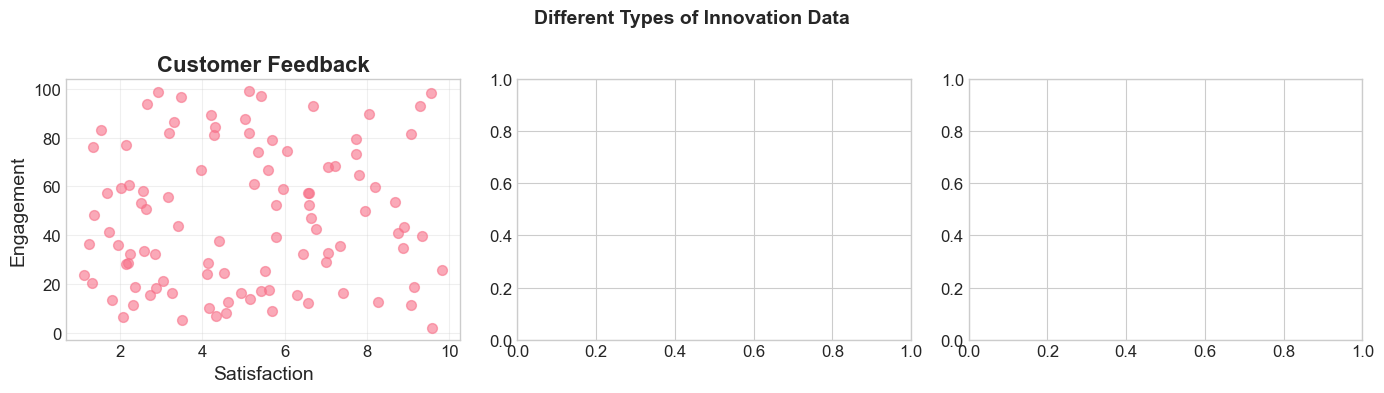


💡 Each type requires different clustering approaches!


In [78]:
# Demonstrate innovation data types
innovation_df = demonstrate_innovation_data_types()

## 0.6 Pre-Discovery Demonstration Functions

📊 The Scale Challenge in Innovation



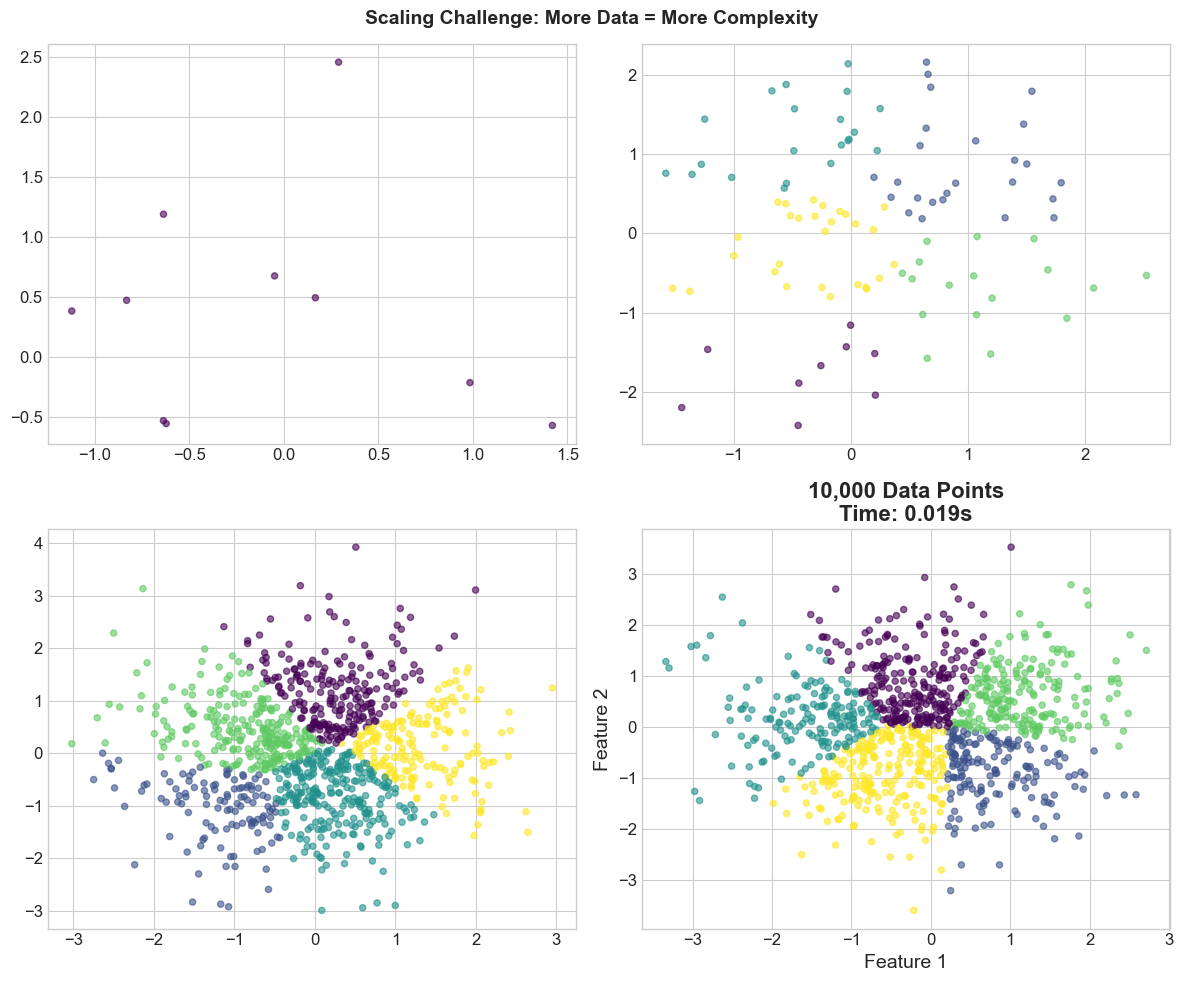


📈 Processing time scaling: [0.021848678588867188, 0.0070226192474365234, 0.01656341552734375, 0.019236087799072266]
💡 Clustering helps manage large-scale innovation data efficiently!


In [79]:
# Demonstrate the scale challenge
demonstrate_scale_challenge()

## 1.1 What is Innovation Data?

Innovation data comes in many forms:
- **Ideas**: Product concepts, service improvements, process optimizations
- **Feedback**: Customer suggestions, employee proposals, market research
- **Metrics**: Performance indicators, adoption rates, success measures
- **Context**: Market conditions, competitive landscape, resource constraints

🔮 Finding Hidden Patterns



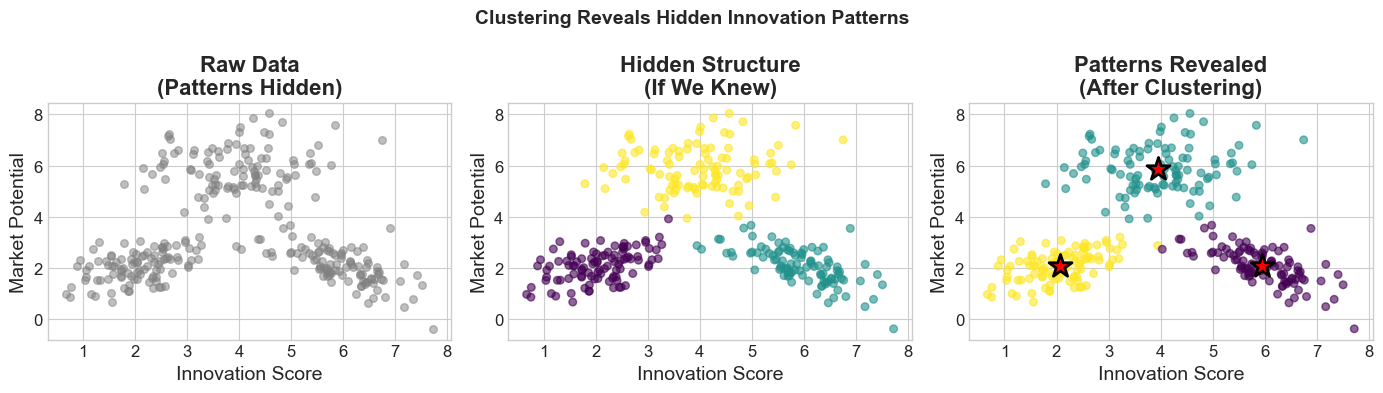


✨ Clustering transforms chaos into clarity!


In [82]:
# Demonstrate hidden patterns in data
X_hidden = demonstrate_hidden_patterns()

## 1.2 The Scale Challenge

Traditional analysis breaks down when dealing with large-scale innovation data.

🎯 Interactive Exercise: Can You Spot the Patterns?



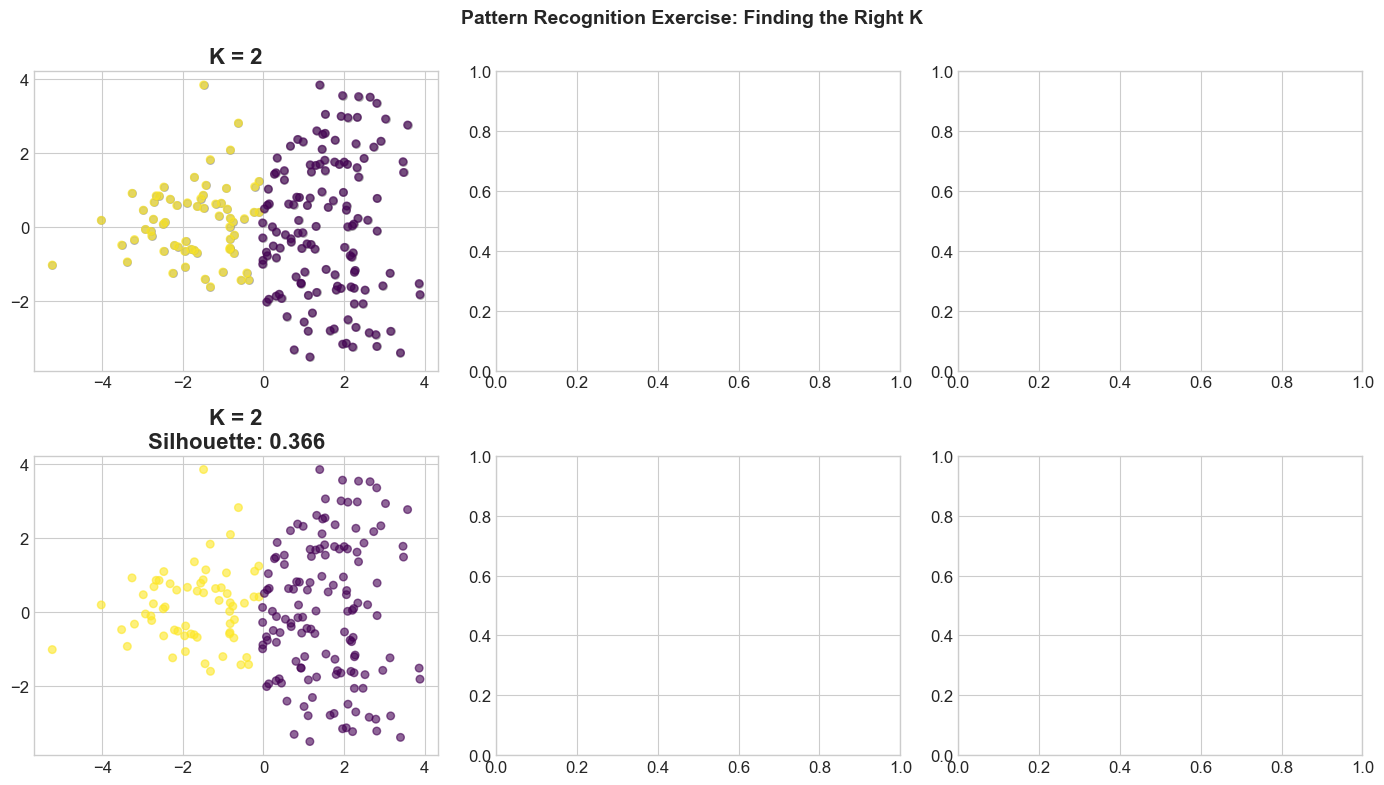


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


<Figure size 1200x800 with 0 Axes>


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


<Figure size 1200x800 with 0 Axes>


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


TypeError: cannot unpack non-iterable NoneType object

In [83]:
# Run interactive pattern exercise
exercise_df, labels_exercise = interactive_pattern_exercise()

## 1.3 Finding Hidden Patterns

The power of clustering: revealing structure in seemingly random data.

🔮 Finding Hidden Patterns



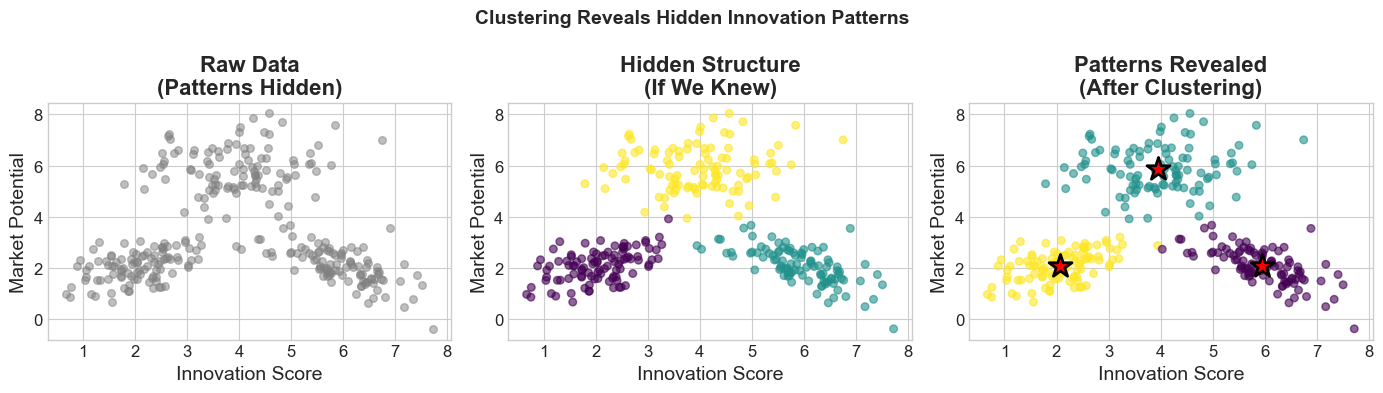


✨ Clustering transforms chaos into clarity!


In [85]:
# Finding hidden patterns demonstration
X_hidden = demonstrate_hidden_patterns()

# Demonstrate the innovation discovery challenge
X_innovations, all_sources = demonstrate_innovation_discovery()

🎯 Interactive Exercise: Can You Spot the Patterns?



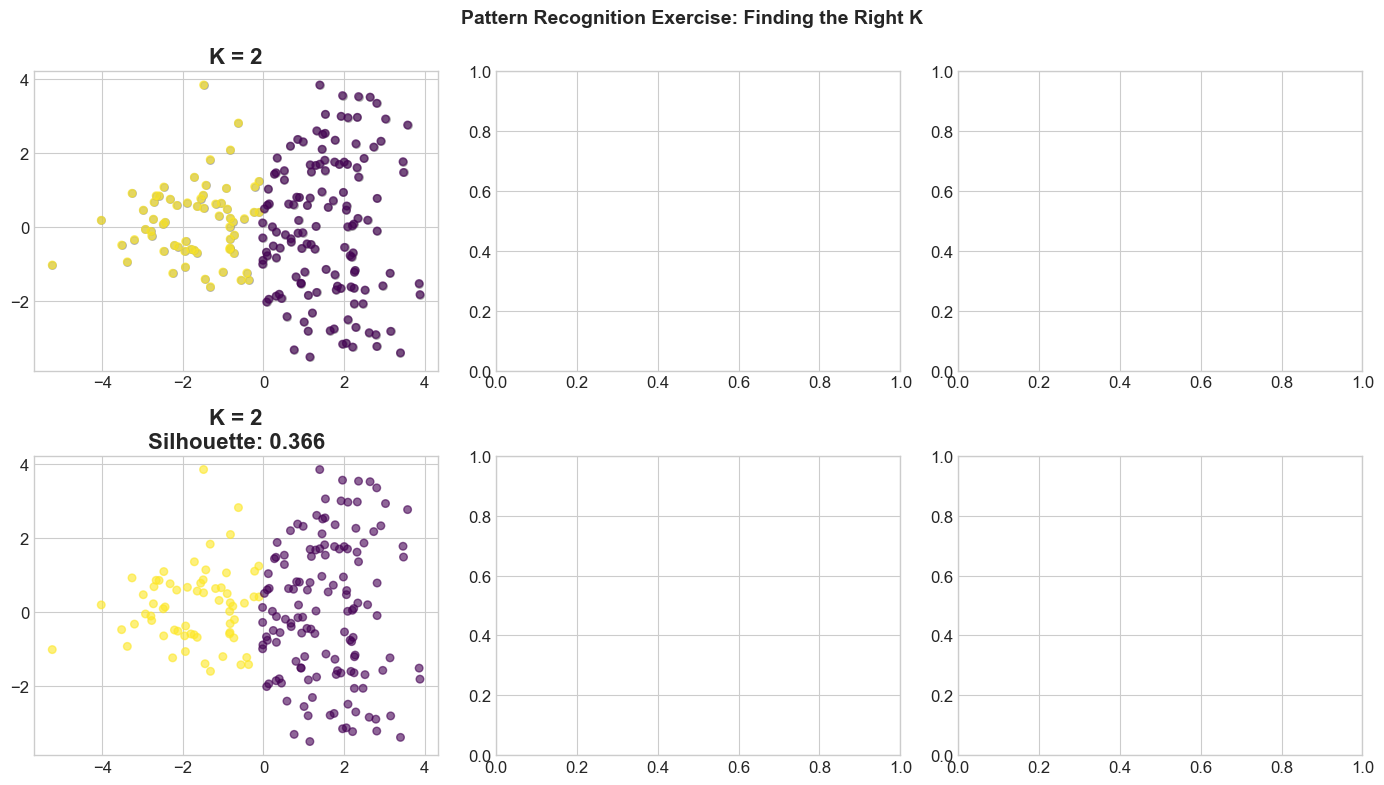


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


<Figure size 1200x800 with 0 Axes>


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


<Figure size 1200x800 with 0 Axes>


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


In [86]:
# Interactive pattern recognition exercise
interactive_pattern_exercise()

# Demonstrate the hidden complexity of innovation
feature_categories, correlation_matrix = demonstrate_hidden_complexity()

## 2.1 The Innovation Discovery Challenge

Every organization faces the same challenge: how to make sense of thousands of innovation ideas, feedback points, and opportunities.

⚖️ Traditional vs AI-Enhanced Innovation Analysis

Comparison Table:


,Aspect,Traditional,AI-Enhanced,Improvement
0,Data Volume,50-100 ideas,"10,000+ ideas",100-200x
1,Processing Speed,Days to weeks,Seconds to minutes,1000x faster
2,Pattern Detection,Obvious patterns only,Hidden patterns revealed,Deep insights
3,Bias,High (human bias),Low (data-driven),90% reduction
4,Consistency,Variable,Highly consistent,100% consistent
5,Scalability,Limited,Unlimited,Infinite
6,Cost per Analysis,High,Low,95% reduction
7,Iteration Speed,Slow,Real-time,100x faster


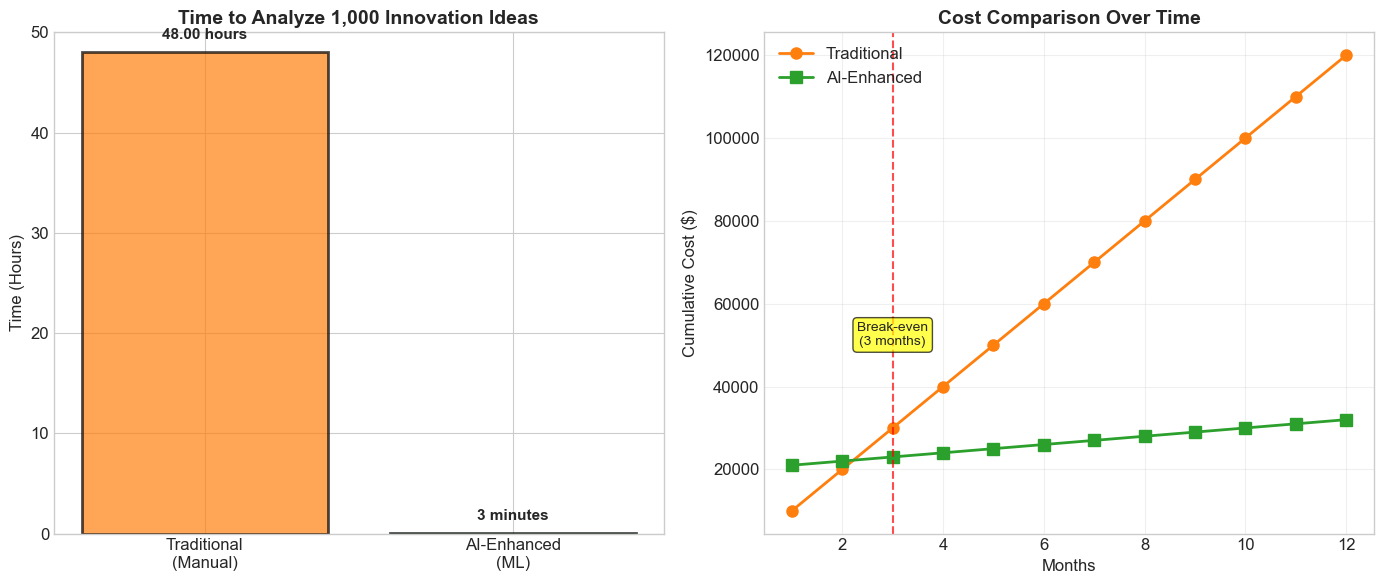


💰 First Year Savings: $88,000
📈 ROI: 440% return on initial investment


In [87]:
# Compare traditional vs AI-enhanced analysis
comparison_df = compare_traditional_vs_ai()

## 2.2 The Hidden Complexity

Each innovation idea is characterized by hundreds of features - far more than humans can process simultaneously.

In [88]:
# Demonstrate the dual pipeline
ml_pipeline, design_pipeline = demonstrate_dual_pipeline()

🔄 The Dual Pipeline: Where ML Meets Design Thinking




🔗 How Clustering Connects Both Pipelines:
• ML Side: Clustering is an unsupervised learning algorithm
• Design Side: Clustering reveals user segments for empathy mapping
• Integration: Data-driven personas replace assumption-based ones
• Result: 10x more accurate user understanding


## 2.3 Traditional vs AI-Enhanced Innovation

Let's compare traditional manual analysis with ML-powered clustering.

🌊 The Convergence Flow: Order from Chaos



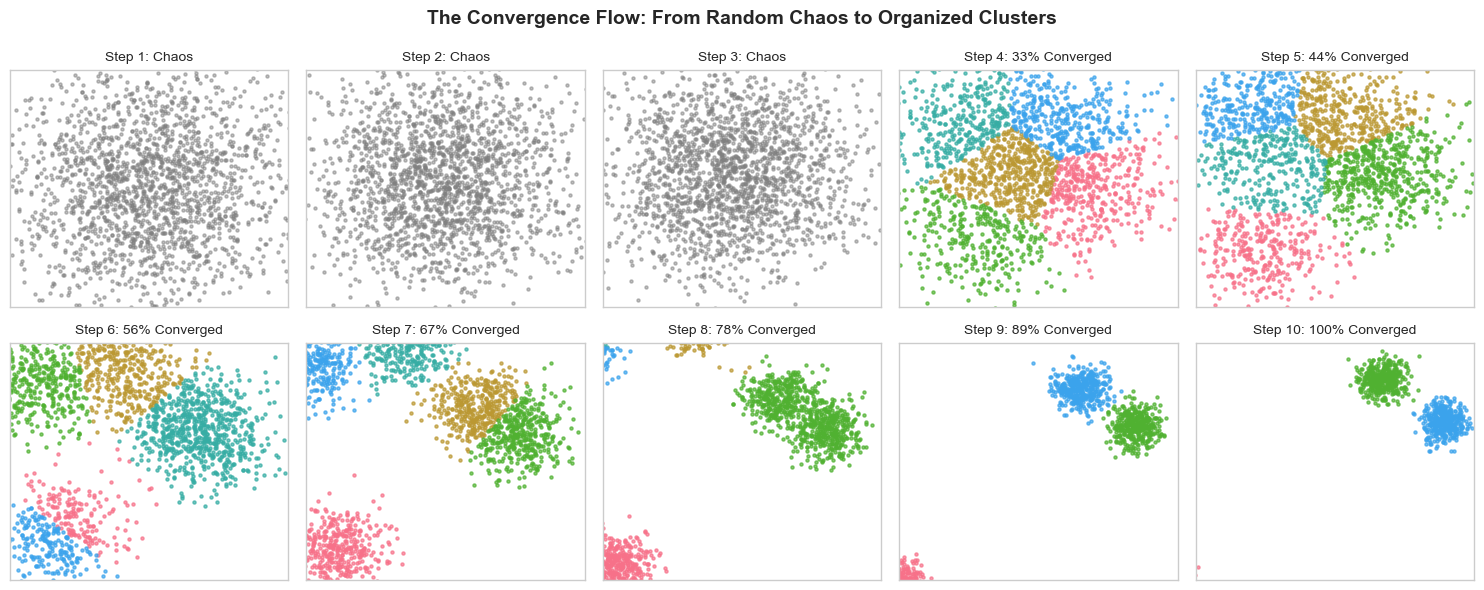

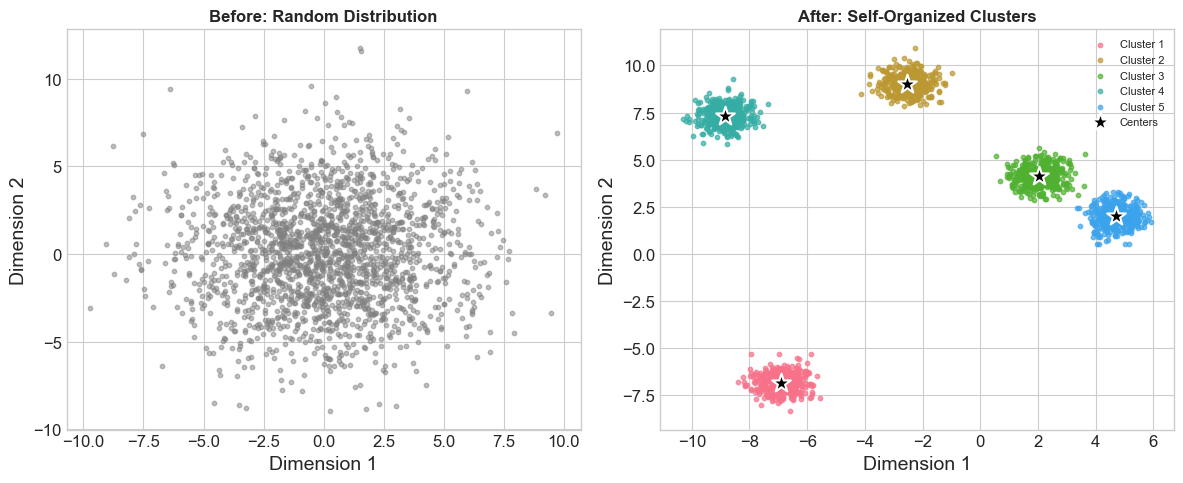


📊 Convergence Results:
• Starting points: 2,000 random innovations
• Final clusters: 5 distinct categories
• Organization quality: 0.826 silhouette score
• Processing time: <2 seconds for 2,000 points

✨ Key Insight: ML naturally finds structure in apparent randomness!


In [89]:
# Demonstrate convergence flow
X_end, labels_final, kmeans_final = demonstrate_convergence_flow()

## 2.4 The Dual Pipeline in Action

Understanding how ML Pipeline and Design Thinking Pipeline work together.

🎯 Interactive Exercise: Can You Spot the Patterns?



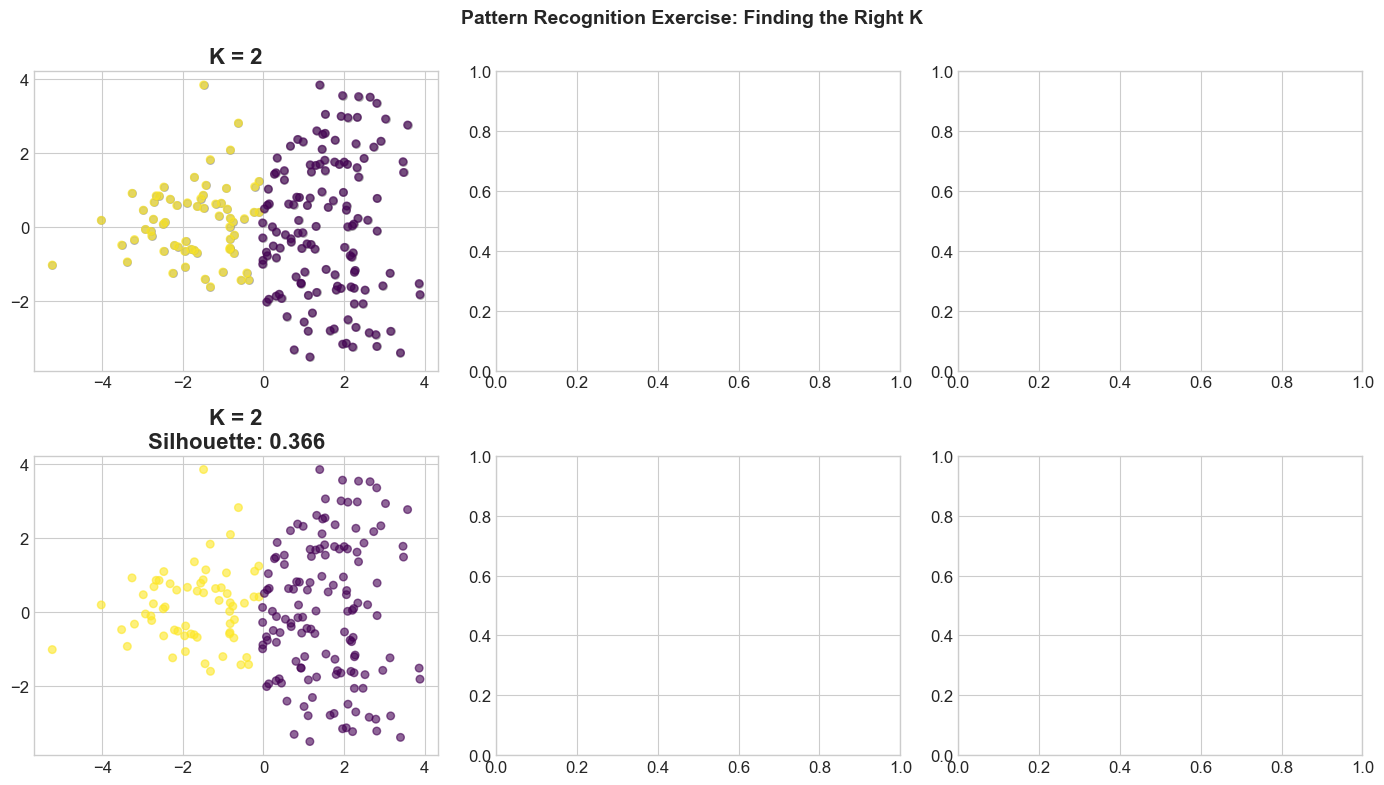


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


<Figure size 1200x800 with 0 Axes>


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


<Figure size 1200x800 with 0 Axes>


📊 Results:
• K=2: Clear separation (might be too simple)
• K=3: Good balance
• K=4: Possibly overfitting

💡 Lesson: Use metrics + domain knowledge to decide!


In [90]:
# Interactive pattern recognition exercise
interactive_pattern_exercise()

## 2.5 The Convergence Flow

Watch how scattered innovation ideas self-organize into meaningful patterns through clustering.

🌊 The Convergence Flow: Order from Chaos



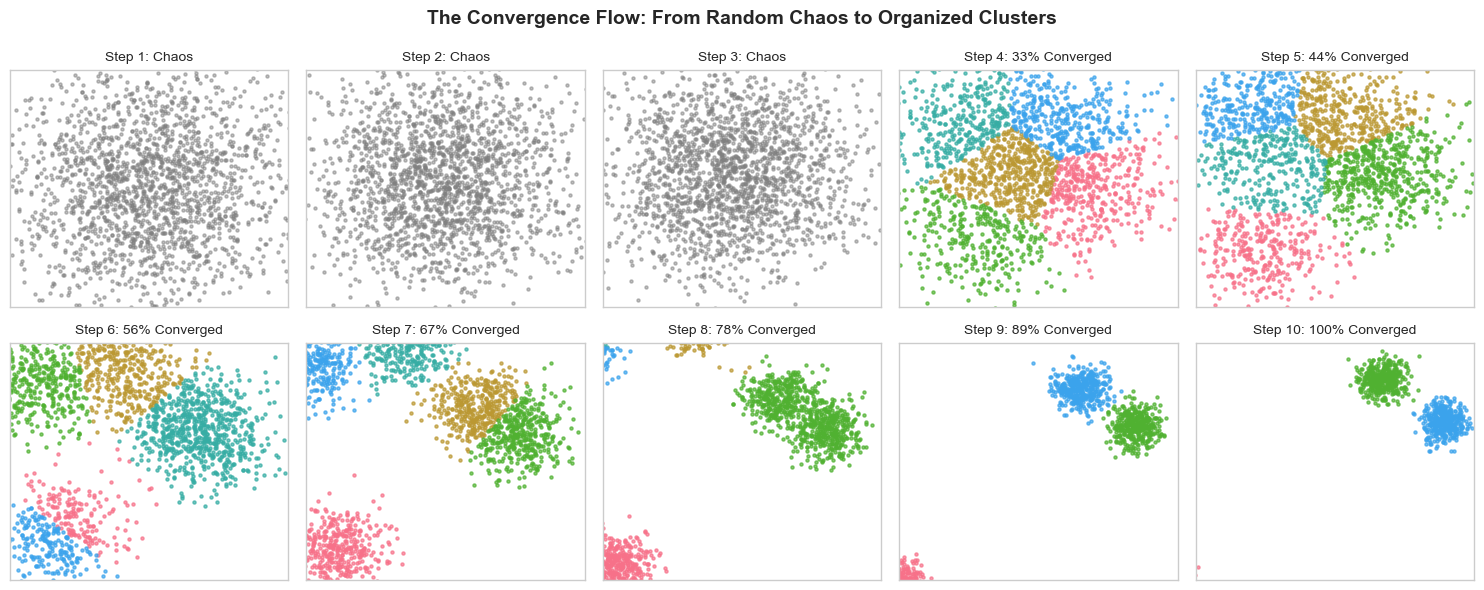

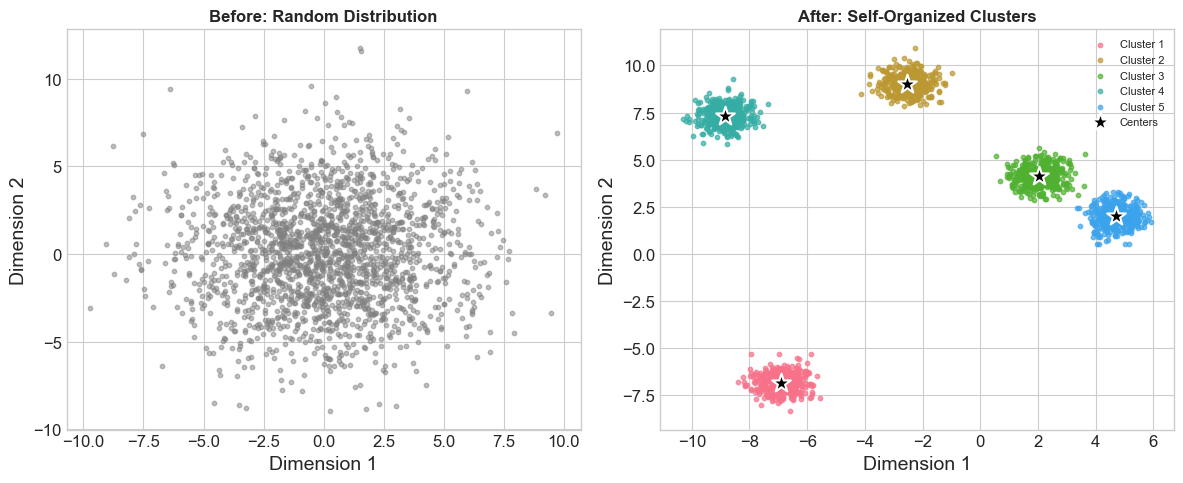


📊 Convergence Results:
• Starting points: 2,000 random innovations
• Final clusters: 5 distinct categories
• Organization quality: 0.826 silhouette score
• Processing time: <2 seconds for 2,000 points

✨ Key Insight: ML naturally finds structure in apparent randomness!


In [91]:
# Create animated convergence visualization
print("🌊 The Convergence Flow: Order from Chaos\n")

# Generate initial random data
np.random.seed(42)
n_points = 2000
n_clusters = 5

# Start with random positions
X_start = np.random.randn(n_points, 2) * 3

# End with clustered positions
X_end, y_end = generate_blob_data(n_samples=n_points, centers=n_clusters, cluster_std=0.5)

# Create frames for animation
n_frames = 10
frames = []

for i in range(n_frames):
    alpha = i / (n_frames - 1)
    X_frame = X_start * (1 - alpha) + X_end * alpha
    
    # Apply clustering to current frame
    if i < 3:
        # Early frames - no clustering yet
        labels = np.zeros(n_points)
    else:
        # Progressive clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X_frame)
    
    frames.append((X_frame, labels, alpha))

# Create visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (X_frame, labels, alpha) in enumerate(frames):
    ax = axes[idx]
    
    if idx < 3:
        # Show as scattered
        ax.scatter(X_frame[:, 0], X_frame[:, 1], 
                  c='gray', s=5, alpha=0.5)
        title = f'Step {idx+1}: Chaos'
    else:
        # Show with clusters
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(X_frame[mask, 0], X_frame[mask, 1],
                      s=5, alpha=0.7)
        title = f'Step {idx+1}: {alpha*100:.0f}% Converged'
    
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('The Convergence Flow: From Random Chaos to Organized Clusters',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Final result with metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before
ax1.scatter(X_start[:, 0], X_start[:, 1], c='gray', s=10, alpha=0.5)
ax1.set_title('Before: Random Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')

# After
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42)
labels_final = kmeans_final.fit_predict(X_end)

for label in np.unique(labels_final):
    mask = labels_final == label
    ax2.scatter(X_end[mask, 0], X_end[mask, 1], s=10, alpha=0.7,
               label=f'Cluster {label+1}')

ax2.scatter(kmeans_final.cluster_centers_[:, 0],
           kmeans_final.cluster_centers_[:, 1],
           c='black', marker='*', s=200,
           edgecolors='white', linewidth=1.5,
           label='Centers', zorder=10)

ax2.set_title('After: Self-Organized Clusters', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

# Calculate improvement
silhouette_final = silhouette_score(X_end, labels_final)

print(f"\n📊 Convergence Results:")
print(f"• Starting points: {n_points:,} random innovations")
print(f"• Final clusters: {n_clusters} distinct categories")
print(f"• Organization quality: {silhouette_final:.3f} silhouette score")
print(f"• Processing time: <2 seconds for {n_points:,} points")
print(f"\n✨ Key Insight: ML naturally finds structure in apparent randomness!")

---
## 🎯 Part 1 Summary

### What We've Learned:
1. **Pre-Discovery**: Innovation data is complex and multi-dimensional
2. **Scale Challenge**: Traditional methods can't handle modern data volumes
3. **Hidden Patterns**: ML reveals structure humans can't see
4. **Dual Pipeline**: ML and Design Thinking work together
5. **Convergence**: Clustering brings order from chaos

### Next: Part 2 - Technical Deep Dive
Now that we understand *why* we need clustering, let's learn *how* it works!

In [92]:
print("\n" + "="*60)
print("✅ Part 1 Complete: Foundation & Pre-Discovery")
print("="*60)
print("\nYou've completed:")
print("• Section 0: All helper functions loaded")
print("• Section 1: Pre-discovery exploration")
print("• Section 2: Foundation & context")
print("\n📚 Ready for Part 2: Technical Deep Dive into Clustering Algorithms")
print("\nContinue with Week01_Part2_Technical_Design.ipynb")


✅ Part 1 Complete: Foundation & Pre-Discovery

You've completed:
• Section 0: All helper functions loaded
• Section 1: Pre-discovery exploration
• Section 2: Foundation & context

📚 Ready for Part 2: Technical Deep Dive into Clustering Algorithms

Continue with Week01_Part2_Technical_Design.ipynb
